<a href="https://colab.research.google.com/github/wphall/CO2-Equilibrium/blob/main/Instructor_Notebook_CO2_Equilibrium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using [Python](https://www.oreilly.com/content/a-whirlwind-tour-of-python/) and some fundamental libraries for scientific computing
* [Numpy](https://numpy.org/doc/stable/user/absolute_beginners.html) for calculations: dealing with arrays and bracket notation
* [Matplotlib](https://matplotlib.org/stable/users/explain/quick_start.html) for graphing: handling figures and axes, labeling axes with mathtext, annotation, colors
* [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html#) for large data sets: addressing the contents of a dataset by name and by index, comunicating with a spresheet
* [Scipy](https://docs.scipy.org/doc/scipy/tutorial/index.html) for functions: what the library contains and its organization, reading function documentation and using named arguments
* Fundamental [flow control concepts](https://docs.python.org/3/tutorial/controlflow.html#): functions, loops, and conditional statements

Equilibrium
* complex equilibrium involving more than one reaction
* charge balance and mass balance to provide additional constraints
* effect of activity and temperature

Environmental chemistry
* changes in atmospheric carbon dioxide, ocean acidification, and the "other" $CO_2$ problem
* DIC, pH, and aragonite saturation

In [3]:
import numpy as np                    #the numpy library contains fast math functions designed to operate on and store arrays of numbers
import pandas as pd                   #the pandas library deals with named columns and rows of data called a dataframe (similar to an Excel worksheet with customizable row and column labels)
from google.colab import data_table   #this colab library supports nice display (formatting) and interaction (sorting, downloading) with tables of data including pandas dataframes

data_table.enable_dataframe_formatter()                       #turn on interactive, nice formatting of tabular data
data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.3e}"  #change the default number format to be scientific notation with 3 digits after the decimal

Kh=3.40e-2            #Kh  = co2/atm      = x[1]/x[0]
Ka1=4.46e-7           #Ka1 = hdr*bct/co2  = x[4]*x[2]/x[1]
Ka2=4.69e-11          #Ka2 = hdr*car/bct  = x[4]*x[3]/x[2]
Kw=1.0e-14            #Kw  = hdr*hox      = x[4]*x[5]
Ksp=4.6e-9            #Ksp = cal*car      = x[6]*x[3]

ppm=425
atm=ppm/1.0e6
co2=atm*Kh
bct=np.sqrt(Ka1*co2)
hdr=np.sqrt(Ka1*co2)
hox=Kw/hdr
car=Ka2
cal=0.0

xguess=np.array([atm,co2,bct,car,hdr,hox,cal])                              #here we pack the seven individual amounts into an array, which we will need later to pass into our function
print(xguess)
dfResults=pd.DataFrame(columns=["atm","co2","bct","car","hdr","hox","cal"]) #here we make an empty dataframe to hold all our results with 7 named columns, one for each unknown
dfAll=pd.DataFrame(columns=["atm","co2","bct","car","hdr","hox","cal"]) #here we make an empty dataframe to hold all our results with 7 named columns, one for each unknown
dfAll.loc["CO2_Only Start"]=xguess                                      #here we place our initial guesses for the concentrations into the dataframe with a row location of ""CO2_Only Start"
dfAll                                                                   #this line will display the entire dataframe in that nicely formatted output we enabled at the start of the code block

[4.25000000e-04 1.44500000e-05 2.53864137e-06 4.69000000e-11
 2.53864137e-06 3.93911488e-09 0.00000000e+00]


,atm,co2,bct,car,hdr,hox,cal
CO2_Only Start,0.000425,0.000014,0.000003,4.690000e-11,0.000003,3.939115e-09,0.0


1. importing libraries with an alias
2. calling a function and storing the result as a variable
3. storing a variable in a numpy array
4. storing an array in a dataframe and [use of .loc](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#selection-by-label)

?consider: dry air, effect of temperature and humidity https://gml.noaa.gov/ccgg/about/co2_measurements.html

In [4]:
def FunCO2OnlyFixed(x):                     #input is an array called "x" in the variable scope of the function, indexing starts with zero
    f0=x[1]-(Kh)*(x[0])                     #Henry's Law
    f1=x[4]*x[2]-(Ka1*x[1])                 #Ka1 of dissolved CO2 to bicarbonate
    f2=x[4]*x[3]-(Ka2*x[2])                 #Ka2 of bicarbonate to carbonate
    f3=x[4]*x[5]-Kw                         #Kw, dissociation of water
    f4=x[6]                                 #[calcium]=0
    f5=x[4]+2*x[6]-x[2]-2*x[3]-x[5]         #charge balance positive minus negative
    f6=x[0]-atm                             #partial pressure is constant and always equal to the value stored in the variable atm
    return np.array([f0,f1,f2,f3,f4,f5,f6]) #return the signed residual of each eqaution

print(FunCO2OnlyFixed(xguess))

[ 0.00000000e+00 -8.07793567e-28  0.00000000e+00 -1.57772181e-30
  0.00000000e+00 -4.03291488e-09  0.00000000e+00]


1. creating a new function with using "def" and line indentation
2. returning a set of values as an array
3. the initial guesses are very close, only charge balance needs tweaking due to a slight excess of negative charge.  We are failing to account for the small amount of hydronium produced by Ka2

In [5]:
def FunCO2OnlyFinite(x):
    f0=x[1]-(Kh)*(x[0])
    f1=x[4]*x[2]-(Ka1*x[1])
    f2=x[4]*x[3]-(Ka2*x[2])
    f3=x[4]*x[5]-Kw
    f4=x[6]
    f5=x[4]+2*x[6]-x[2]-2*x[3]-x[5]
    f6=x[1]+x[2]+x[3]-(Kh*atm)              #allows partial pressure of CO2 (x[0]) to change and limits the amount of dissolved carbon
    return np.array([f0,f1,f2,f3,f4,f5,f6])
print(FunCO2OnlyFinite(xguess))

[ 0.00000000e+00 -8.07793567e-28  0.00000000e+00 -1.57772181e-30
  0.00000000e+00 -4.03291488e-09  2.53868827e-06]


1. Our initial guesses are an overestimate of the amount of dissolved inorganic carbon (DIC=x[1]+x[2]+x[3]) if the atmospheric supply is finite.
2. In order to get bounds for mass balance, we consider an upper bound for DIC (atmospheric supply is unlimited and constant) and a lower bound for DIC (total dissolved carbon is limited to the initial partial pressure).  The difference between the upper and lower bound is small and becomes less significant as the partial pressure of CO2 increases.
3. Some instructors may prefer to ignore this small difference to give students more time with later issues that have a greater impact on their calculations.
Note: We could not use then bound below, because it, combined with f0, would force carbonate and bicarbonate to be zero
      ```
      f6=x[1]+x[2]+x[3]-(Kh*x[0])
      ```

In [25]:
from scipy.optimize import fsolve

xFix=fsolve(FunCO2OnlyFixed,xguess)
print(FunCO2OnlyFixed(xFix))
errorFix=np.sqrt(np.sum(FunCO2OnlyFixed(xFix)**2))
print("errorFix = ",errorFix)
dfResults.loc["CO2 Only"]=xFix

xFin=fsolve(FunCO2OnlyFinite,xguess)
print(FunCO2OnlyFinite(xFin))
errorFin=np.sqrt(np.sum(FunCO2OnlyFinite(xFin)**2))
print("errorFin = ",errorFin)
dfAll.loc["CO2_Only Opt Variable"]=xFin

dfResults

[ 0.00000000e+00 -7.88406521e-25  1.11455239e-24 -4.91750645e-25
 -3.83963185e-34 -6.56781406e-22  0.00000000e+00]
errorFix =  6.567830093570553e-22
[ 1.69406589e-21 -1.06693374e-23 -1.24083087e-25 -3.29392658e-23
 -7.31863161e-37  2.82895769e-22  0.00000000e+00]
errorFin =  1.7178731375513127e-21


,atm,co2,bct,car,hdr,hox,cal
CO2 Only,4.200000e-04,1.346521e-05,0.000004,9.778862e-10,4.222632e-06,9.634802e-09,-3.839632e-34
CC Only,6.495223e-07,2.208376e-08,0.000088,3.673172e-05,1.121424e-10,8.917236e-05,1.252324e-04
CO2+CC,4.200000e-04,1.428000e-05,0.001071,8.444724e-06,5.947374e-09,1.681414e-06,5.447188e-04
"CO2+CC, S=35g/kg",4.200000e-04,1.374442e-05,0.002385,2.895950e-04,7.399693e-09,5.159432e-06,1.484844e-03


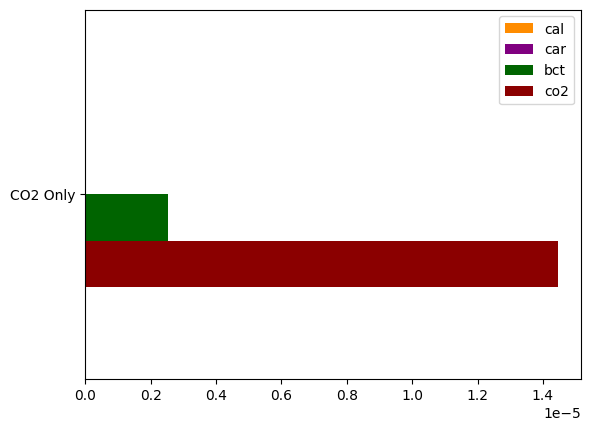

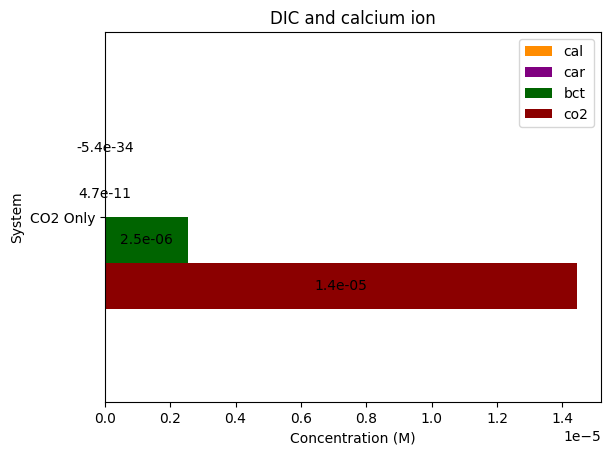

In [7]:
import matplotlib.pyplot as plt

chartColors=["DarkRed","DarkGreen","Purple","DarkOrange"]
dfResults[['co2','bct','car','cal']].plot.barh(color=chartColors)
plt.legend(loc='upper right',reverse=True)

#or
#chartColors = ['#0771eb','#ce59bf','#fc657d','#ee9550']
#from https://www.learnui.design/tools/data-color-picker.html#palette

ax = dfResults[['co2','bct','car','cal']].plot(kind='barh', color=chartColors, rot=0, ylabel='System', xlabel='Concentration (M)',title="DIC and calcium ion")
for c in ax.containers:
    ax.bar_label(c, fmt='%.1e', label_type='center')
plt.legend(loc='upper right',reverse=True)

In [8]:
ppmRange=np.arange(100,510,10)
print("Concentration range = ",ppmRange)
print("Number of pressures = ",len(ppmRange))

#alternative syntax
#this one does return a floting point value and the labels do not look as nice
#ppmRange=np.linspace(100,500,41)
#print("Concentration range = ",ppmRange)
#print("Number of pressures = ",len(ppmRange))

ppmIndexes=np.arange(len(ppmRange))
print("Index of each pressure ",ppmIndexes)

dfRangeFix=pd.DataFrame(index=ppmRange,columns=["atm","co2","bct","car","hdr","hox","cal"])
dfRangeFin=pd.DataFrame(index=ppmRange,columns=["atm","co2","bct","car","hdr","hox","cal"])
print(dfRangeFix)

Concentration range =  [100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270
 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450
 460 470 480 490 500]
Number of pressures =  41
Index of each pressure  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
     atm  co2  bct  car  hdr  hox  cal
100  NaN  NaN  NaN  NaN  NaN  NaN  NaN
110  NaN  NaN  NaN  NaN  NaN  NaN  NaN
120  NaN  NaN  NaN  NaN  NaN  NaN  NaN
130  NaN  NaN  NaN  NaN  NaN  NaN  NaN
140  NaN  NaN  NaN  NaN  NaN  NaN  NaN
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN
160  NaN  NaN  NaN  NaN  NaN  NaN  NaN
170  NaN  NaN  NaN  NaN  NaN  NaN  NaN
180  NaN  NaN  NaN  NaN  NaN  NaN  NaN
190  NaN  NaN  NaN  NaN  NaN  NaN  NaN
200  NaN  NaN  NaN  NaN  NaN  NaN  NaN
210  NaN  NaN  NaN  NaN  NaN  NaN  NaN
220  NaN  NaN  NaN  NaN  NaN  NaN  NaN
230  NaN  NaN  NaN  NaN  NaN  NaN  NaN
240  NaN  NaN  NaN  NaN  NaN  NaN  NaN
250  NaN 

In [9]:
for ppm,index in zip(ppmRange,ppmIndexes):     #this loop will step through the mixing ratios
  atm=ppm/1.0e6
  co2=atm*Kh            #calculates the initial dissolved CO2 using Henry's Law constant
  bct=np.sqrt(Ka1*co2)  #initial guess for bicarbonate concentration based on Ka1
  hdr=np.sqrt(Ka1*co2)  #initial guess for hydronium concentration based on Ka1
  hox=Kw/hdr            #initial guess for hydroxide concentration based on hydronium from Ka1
  car=Ka2               #initial guess for carbonate concentration based Ka2 (bct/hdr=1)
  cal=0.0               #initial guess for calcium is zero
  xguess=np.array([atm,co2,bct,car,hdr,hox,cal])
  xFix=fsolve(FunCO2OnlyFixed,xguess) #find the 7 concentrations to satisfy the 7 equations
  dfRangeFix.iloc[index,:]=xFix       #store them in the dataframe in the appropriate row of the table and repeat the loop
  xFin=fsolve(FunCO2OnlyFinite,xguess)#find the 7 concentrations to satisfy the 7 equations
  dfRangeFin.iloc[index,:]=xFin       #store them in the dataframe in the appropriate row of the table and repeat the loop

pHFix=-np.log10(np.array(dfRangeFix["hdr"],dtype=float))
pHFin=-np.log10(np.array(dfRangeFin["hdr"],dtype=float))

print(pHFix)
print(pHFin)

[5.90814944 5.88758322 5.86879745 5.85150829 5.83549476 5.8205815
 5.80662697 5.79351532 5.7811505  5.769452   5.75835166 5.74779127
 5.73772074 5.72809662 5.71888101 5.71004065 5.70154615 5.69337148
 5.68549342 5.6778912  5.67054616 5.66344146 5.65656187 5.64989356
 5.64342394 5.63714152 5.63103576 5.62509699 5.61931634 5.61368559
 5.60819716 5.60284405 5.59761973 5.59251816 5.5875337  5.58266109
 5.57789542 5.5732321  5.56866683 5.56419557 5.55981452]
[5.98539439 5.96136236 5.93953771 5.91955574 5.90113456 5.88405187
 5.86812935 5.85322181 5.83920955 5.82599268 5.81348704 5.80162108
 5.79033344 5.77957113 5.76928807 5.75944397 5.75000336 5.7409349
 5.73221071 5.72380594 5.71569831 5.70786778 5.70029625 5.69296735
 5.68586618 5.67897917 5.67229394 5.66579913 5.65948431 5.65333988
 5.64735699 5.64152744 5.63584367 5.63029862 5.62488577 5.61959901
 5.61443267 5.60938144 5.60444034 5.59960474 5.59487026]


need to explain iloc vs loc

Python has a [mini-language for specifing the formatting of strings](https://docs.python.org/3.4/library/string.html#formatspec).

Basic usage is:
str="{:.&precision& &type& }".format(number)
*   &precision& is a number that specifies the precision (number of digits)
*   &type& is a charater that specifies the type of notation

Examples
"{:.2e}".format(num)
"{:.3f}".format(num)
"{:.1%}".format(num)

5.63


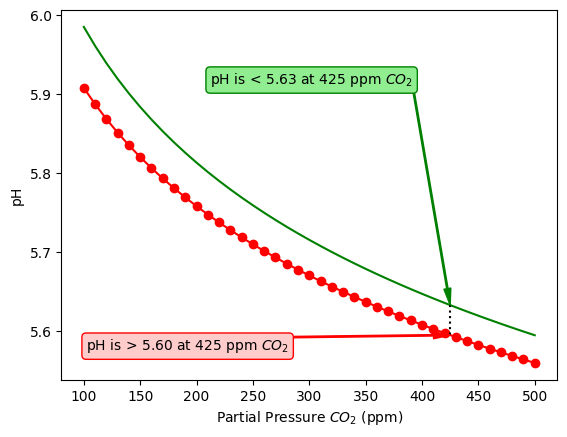

In [10]:
fig,ax=plt.subplots()
ax.plot(ppmRange,pHFix, linestyle='solid', marker='o', color="red")
ax.plot(ppmRange,pHFin, "-g")
ax.set_xlabel("Partial Pressure $CO_2$ (ppm)")
ax.set_ylabel("pH")

ppmNow=425
#use a close guess from the table
atm=ppmNow/1e6
xguess=np.array([atm,co2,bct,car,hdr,hox,cal])
xFix=fsolve(FunCO2OnlyFixed,xguess)
xFin=fsolve(FunCO2OnlyFinite,xguess)

pHNowFin=-np.log10(xFin[4])
str_pHNowFin="{:.2f}".format(pHNowFin)
print(str_pHNowFin)
ax.annotate('pH is < '+str(str_pHNowFin)+" at "+str(ppmNow)+" ppm $CO_2$",
            xy=(ppmNow, pHNowFin), xycoords='data',                           #"data' is the default unit for graph coodinates
            xytext=(0.3, 0.8), textcoords='axes fraction',                    #'axes fraction' is (x,y) lower left is (0,0) upper right is (1,1)
            arrowprops={'color': 'green', 'width':1, 'headwidth':5},
            bbox={'boxstyle':'round', 'edgecolor':'green','facecolor':'lightGreen'}
            )
pHNowFix=-np.log10(xFix[4])
str_pHNowFix="{:.2f}".format(pHNowFix)
ax.annotate('pH is > '+str(str_pHNowFix)+" at "+str(ppmNow)+" ppm $CO_2$",
            xy=(ppmNow, pHNowFix), xycoords='data',                           #"data' is the default unit for graph coodinates
            xytext=(0.05, 0.08), textcoords='axes fraction',                  #'axes fraction' is (x,y) lower left is (0,0) upper right is (1,1)
            arrowprops={'color': 'red', 'width':1, 'headwidth':5},
            bbox={'boxstyle':'round', 'edgecolor':'red','facecolor':(1,0.8,0.8)}
            )
ax.vlines(ppmNow,pHNowFin,pHNowFix,color='black',linestyle='dotted')
#axYs=ax.twinx()
#axYs.plot(ppmRange,pHFin-pHFix, ":k")
#axYs.set_ylabel("$\Delta$ pH")

Concentration range =  [  6804.596  13609.192  20413.788  27218.384  34022.98   40827.576
  47632.172  54436.768  61241.364  68045.96   74850.556  81655.152
  88459.748  95264.344 102068.94  108873.536 115678.132 122482.728
 129287.324 136091.92  142896.516 149701.112 156505.708 163310.304
 170114.9   176919.496 183724.092 190528.688 197333.284 204137.88
 210942.476 217747.072 224551.668 231356.264 238160.86  244965.456
 251770.052 258574.648 265379.244 272183.84  278988.436 285793.032
 292597.628 299402.224 306206.82  313011.416 319816.012 326620.608
 333425.204 340229.8   347034.396 353838.992 360643.588 367448.184
 374252.78  381057.376 387861.972 394666.568 401471.164 408275.76
 415080.356 421884.952 428689.548 435494.144 442298.74  449103.336
 455907.932 462712.528 469517.124 476321.72  483126.316 489930.912
 496735.508 503540.104 510344.7   517149.296 523953.892 530758.488
 537563.084 544367.68  551172.276 557976.872 564781.468 571586.064
 578390.66  585195.256 591999.852 598804.

Text(0.3, 0.7, 'At 4.56 psi $\\mathrm{CO_2}$\nmeasured pH is 4.20\ncalculated pH is 4.17')

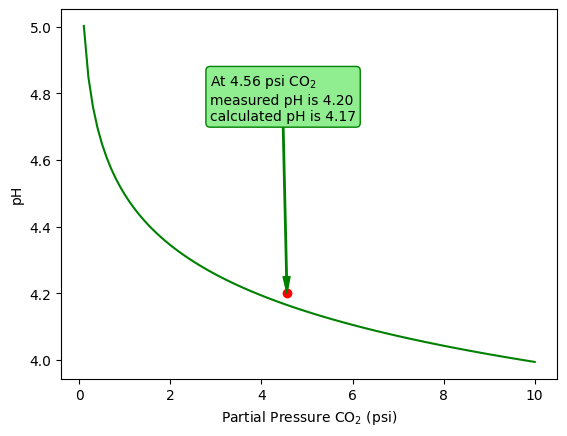

In [11]:
#fig2,ax2=plt.subplots()
#ax2.plot(,(pHFin-pHFix),"-g")
#ax2.set_xlabel("Partial Pressure $CO_2$ (psi)")
#ax2.set_ylabel("pH")
psiRange=np.linspace(.1,10,100)

ppmRange=psiRange*0.06804596*1.0e6
print("Concentration range = ",ppmRange)
print("Number of pressures = ",len(ppmRange))

ppmIndexes=np.arange(len(ppmRange))
print("Index of each pressure ",ppmIndexes)

dfRangeFix=pd.DataFrame(index=psiRange,columns=["atm","co2","bct","car","hdr","hox","cal"])
dfRangeFin=pd.DataFrame(index=psiRange,columns=["atm","co2","bct","car","hdr","hox","cal"])

for ppm,index in zip(ppmRange,ppmIndexes):     #this loop will step through the mixing ratios
  atm=ppm/1.0e6
  co2=atm*Kh            #calculates the initial dissolved CO2 using Henry's Law constant
  bct=np.sqrt(Ka1*co2)  #initial guess for bicarbonate concentration based on Ka1
  hdr=np.sqrt(Ka1*co2)  #initial guess for hydronium concentration based on Ka1
  hox=Kw/hdr            #initial guess for hydroxide concentration based on hydronium from Ka1
  car=Ka2               #initial guess for carbonate concentration based Ka2 (bct/hdr=1)
  cal=0.0               #initial guess for calcium is zero
  xguess=np.array([atm,co2,bct,car,hdr,hox,cal])
  xFix=fsolve(FunCO2OnlyFixed,xguess) #find the 7 concentrations to satisfy the 7 equations
  dfRangeFix.iloc[index,:]=xFix       #store them in the dataframe in the appropriate row of the table and repeat the loop
  xFin=fsolve(FunCO2OnlyFinite,xguess)#find the 7 concentrations to satisfy the 7 equations
  dfRangeFin.iloc[index,:]=xFin       #store them in the dataframe in the appropriate row of the table and repeat the loop

pHFix=-np.log10(np.array(dfRangeFix["hdr"],dtype=float))
pHFin=-np.log10(np.array(dfRangeFin["hdr"],dtype=float))

fig,ax=plt.subplots()
#ax.plot(psiRange,pHFix, linestyle='solid', marker='o', color="red")
ax.plot(psiRange,pHFin, "-g")
ax.set_xlabel("Partial Pressure $\mathrm{CO_2}$ (psi)")
ax.set_ylabel("pH")

#psiExp=[3.21,3.56,4.56,5.56]
#pHExp=[4.21,4.25,4.20,4.10]

psiExp=4.56
pHExp=4.20
ax.plot(psiExp,pHExp, linestyle='none', marker='o', color="red")
str_pHExp="{:.2f}".format(pHExp)

ppmExp=psiExp*0.06804596*1.0e6
atm=ppmExp/1e6
xguess=np.array([atm,co2,bct,car,hdr,hox,cal])
xFix=fsolve(FunCO2OnlyFixed,xguess)
xFin=fsolve(FunCO2OnlyFinite,xguess)

pHCalc=-np.log10(xFin[4])
str_pHCalc="{:.2f}".format(pHCalc)

ax.annotate('At '+str(psiExp)+' psi $\mathrm{CO_2}$\n'+
            'measured pH is '+str(str_pHExp)+'\n'+
            'calculated pH is '+str(str_pHCalc),
            xy=(psiExp, pHExp), xycoords='data',                           #"data' is the default unit for graph coodinates
            xytext=(0.3, 0.7), textcoords='axes fraction',                 #'axes fraction' is (x,y) lower left is (0,0) upper right is (1,1)
            arrowprops={'color': 'green', 'width':1, 'headwidth':5},
            bbox={'boxstyle':'round', 'edgecolor':'green','facecolor':'lightGreen'}
            )

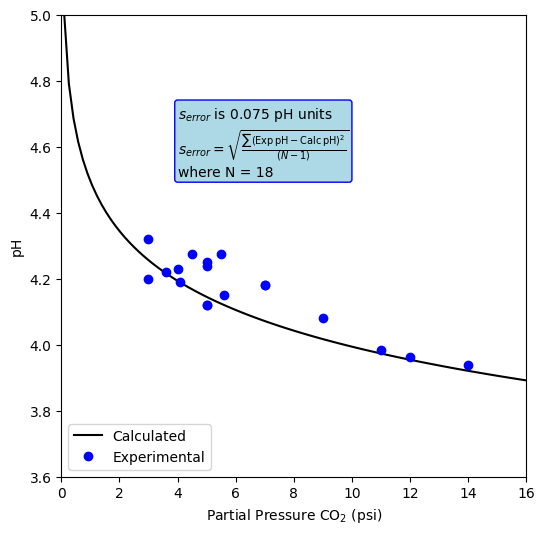

In [12]:
Kh=3.40e-2      #Kh  = co2/atm      = x[1]/x[0]
Ka1=4.46e-7     #Ka1 = hdr*bct/co2  = x[4]*x[2]/x[1]
Ka2=4.69e-11    #Ka2 = hdr*car/bct  = x[4]*x[3]/x[2]
Kw=1.0e-14      #Kw  = hdr*hox      = x[4]*x[5]
Ksp=4.6e-9      #Ksp = cal*car      = x[6]*x[3]

psiRange=np.linspace(.1,16,100)
ppmRange=psiRange*0.06804596*1.0e6
ppmIndexes=np.arange(len(ppmRange))

dfRangeFix=pd.DataFrame(index=psiRange,columns=["atm","co2","bct","car","hdr","hox","cal"])
dfRangeFin=pd.DataFrame(index=psiRange,columns=["atm","co2","bct","car","hdr","hox","cal"])
for ppm,index in zip(ppmRange,ppmIndexes):     #this loop will step through the mixing ratios
  atm=ppm/1.0e6
  co2=atm*Kh            #calculates the initial dissolved CO2 using Henry's Law constant
  bct=np.sqrt(Ka1*co2)  #initial guess for bicarbonate concentration based on Ka1
  hdr=np.sqrt(Ka1*co2)  #initial guess for hydronium concentration based on Ka1
  hox=Kw/hdr            #initial guess for hydroxide concentration based on hydronium from Ka1
  car=Ka2               #initial guess for carbonate concentration based Ka2 (bct/hdr=1)
  cal=0.0               #initial guess for calcium is zero
  xguess=np.array([atm,co2,bct,car,hdr,hox,cal])
  xFix=fsolve(FunCO2OnlyFixed,xguess) #find the 7 concentrations to satisfy the 7 equations
  dfRangeFix.iloc[index,:]=xFix       #store them in the dataframe in the appropriate row of the table and repeat the loop
  xFin=fsolve(FunCO2OnlyFinite,xguess)#find the 7 concentrations to satisfy the 7 equations
  dfRangeFin.iloc[index,:]=xFin       #store them in the dataframe in the appropriate row of the table and repeat the loop

pHFix=-np.log10(np.array(dfRangeFix["hdr"],dtype=float))
pHFin=-np.log10(np.array(dfRangeFin["hdr"],dtype=float))

#fig,ax=plt.subplots(figsize=(3.33,3.33),dpi=300)

fig,ax=plt.subplots(figsize=(6,6))
#ax.plot(psiRange,pHFix, linestyle='solid', marker='o', color="red")
ax.plot(psiRange,pHFin, "-", color="black", label='Calculated')
#ax.plot(psiRange,pHFix, "-b")
ax.set_xlabel("Partial Pressure $\mathrm{CO_2}$ (psi)")
ax.set_ylabel("pH")

psiExp=np.array([11.0, 12.0, 14.0, 4.1, 5.6, 3.6, 5.5, 5.0, 4.5, 5.0, 4.0, 9.0, 5.0, 7.0, 3.0, 3.0, 5.0, 7.0])
pHExp=np.array([3.985, 3.964, 3.94, 4.19, 4.15, 4.22, 4.275, 4.24, 4.275, 4.252, 4.23, 4.08, 4.119, 4.182, 4.32, 4.2, 4.119, 4.182])
yearExp=np.array([2021,2021,2021,2024,2024,2024,2024,2024,2024,2023,2023,2023,2023,2023,2023,2023,2023,2023])
pHCalc=np.zeros(len(pHExp))

#ax.plot(psiExp[yearExp==2021],pHExp[yearExp==2021], linestyle='none', marker='o', color=(0,0,1), label="2021")
#ax.plot(psiExp[yearExp==2023],pHExp[yearExp==2023], linestyle='none', marker='o', color=(.33,.33,1), label="2023")
#ax.plot(psiExp[yearExp==2024],pHExp[yearExp==2024], linestyle='none', marker='o', color=(.66,.66,1), label="2024")
ax.plot(psiExp,pHExp, linestyle='none', marker='o', color=(0,0,1), label="Experimental")

for psi,index in zip(psiExp,range(len(psiExp))):
  ppmExp=psi*0.06804596*1.0e6
  atm=ppmExp/1e6
  xguess=np.array([atm,co2,bct,car,hdr,hox,cal])
  xFix=fsolve(FunCO2OnlyFixed,xguess)
  xFin=fsolve(FunCO2OnlyFinite,xguess)
  pHCalc[index]=-np.log10(np.mean([xFin[4],xFix[4]]))

n=len(pHExp)
residuals=pHExp-pHCalc
stdError=np.sqrt(np.sum(residuals**2)/(n-1))
str_stdError="{:.3f}".format(stdError)

ax.annotate('$s_{error}$ is '+str_stdError+ ' pH units\n'+
            r"$s_{error}=\sqrt{ \frac{\sum{\mathrm{ (Exp \, pH - Calc \, pH)^2}} } {(N-1)}} $"+"\n"
            "where N = "+str(n),
            xy=(np.mean(psiExp), np.mean(pHExp)), xycoords='data',                           #"data' is the default unit for graph coodinates
            xytext=(0.25, 0.65), textcoords='axes fraction',                 #'axes fraction' is (x,y) lower left is (0,0) upper right is (1,1)
            bbox={'boxstyle':'round', 'pad':0.2, 'edgecolor':'blue','facecolor':'lightBlue'}
            )
ax.set_xlim([0,16])
ax.set_ylim([3.6,5])
ax.legend(loc='lower left')

,atm,co2,bct,car,hdr,hox,cal
CO2 Only,4.250000e-04,1.445000e-05,0.000003,4.682561e-11,2.540657e-06,3.935990e-09,-5.396351e-34
CC Only,6.495223e-07,2.208376e-08,0.000088,3.673172e-05,1.121424e-10,8.917236e-05,1.252324e-04


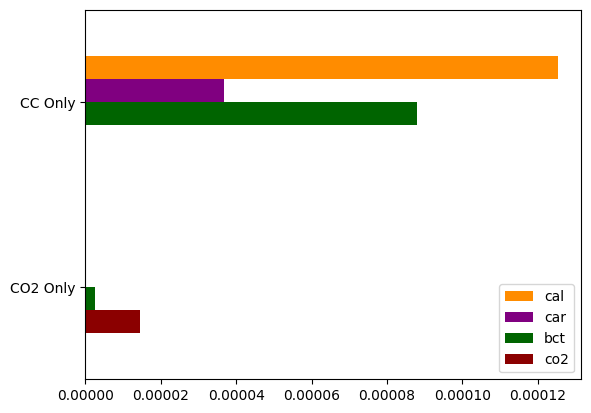

In [13]:
#carbonate only system

def FunCarOnly(x):
    f0=x[1]-(Kh)*(x[0])                         #Henry's Law
    f1=x[4]*x[2]-(Ka1*x[1])                     #Ka1 of dissolved CO2 to bicarbonate
    f2=x[4]*x[3]-(Ka2*x[2])                     #Ka2 of bicarbonate to carbonate
    f3=x[4]*x[5]-Kw                             #dissociation of water
    f4=x[6]*x[3]-Ksp                            #dissociation of calcium carbonate
    f5=x[2]+2*x[3]+x[5]-x[4]-2*x[6]             #charge balance (calcium is included but should not be present in CO2 only system)
    f6=x[6]-x[0]-x[1]-x[2]-x[3]                 #mass balance (here we assume the total amount of carbon is = the total amount of calcium)
    return np.array([f0,f1,f2,f3,f4,f5,f6])

ppm=0                   #CO2 partial pressure starts at zero for carbonate only system
atm=ppm/1.0e6
#initial guesses assuming independent equilibria using Ksp and Kb1 (Kw/Ka2)
co2=0                   #dissolved carbon dioxide starts at zero for carbonate only system
cal=np.sqrt(Ksp)        #initial guess for calcium concentration based on Ksp
# we can't use the "x is small" approximation and must find the roots of the second order polynomial
#  Kb1=x^2/(car-x) so (1*x^2) + (Kb1*x^1) + (-Kb1*car*x^0) = 0
Kb1=Kw/Ka2
rootsKb1 = np.roots([1, Kb1, -Kb1*np.sqrt(Ksp)])    #find all the roots of a polynomial, 2 in this case
posRootKb1=rootsKb1[rootsKb1>0][0]                  #this line finds the single positive root of the quadratic
bct=posRootKb1                                      #initial guess for bicarbonate concentration based on initial carbonate (sqrt(Ksp)) and Kb1
hox=posRootKb1                                      #initial guess for hydroxide concentration based on initial carbonate (sqrt(Ksp)) and Kb1
car=np.sqrt(Ksp)-posRootKb1                         #initial guess for carbonate concentration based on Ksp and amount consumed in Kb1
hdr=Kw/hox                                          #initial guess for hydronium concentration based on hydroxide
x0=np.array([atm,co2,bct,car,hdr,hox,cal])
dfAll.loc["CAR_Only Start"]=x0
x=fsolve(FunCarOnly,x0)
dfResults.loc["CC Only"]=x

dfResults[['co2','bct','car','cal']].plot.barh(color=chartColors,rot=0)
plt.legend(loc='lower right',reverse=True)
dfResults

`xtol` termination condition is satisfied.
4.50580833653841e-28


,atm,co2,bct,car,hdr,hox,cal
CO2 Only,4.250000e-04,1.445000e-05,0.000003,4.682561e-11,2.540657e-06,3.935990e-09,-5.396351e-34
CC Only,6.495223e-07,2.208376e-08,0.000088,3.673172e-05,1.121424e-10,8.917236e-05,1.252324e-04
CO2+CC,4.200000e-04,1.428000e-05,0.001071,8.444724e-06,5.947374e-09,1.681414e-06,5.447188e-04


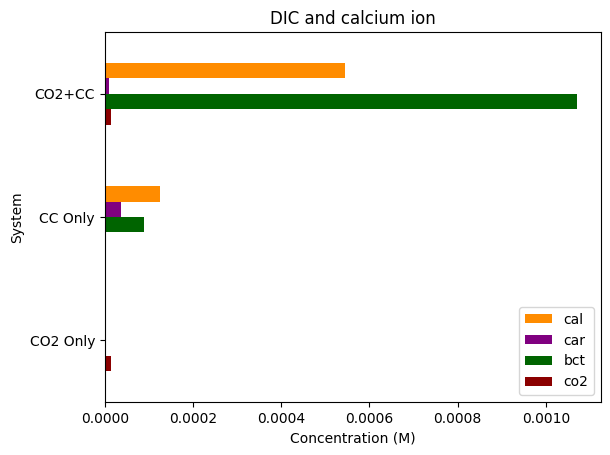

In [14]:
#CO2 and carbonate system

from scipy.optimize import least_squares

def FunCO2Car(x):
    f0=x[1]-(Kh)*(x[0])                         #Henry's Law
    f1=x[4]*x[2]-(Ka1*x[1])                     #Ka1 of dissolved CO2 to bicarbonate
    f2=x[4]*x[3]-(Ka2*x[2])                     #Ka2 of bicarbonate to carbonate
    f3=x[4]*x[5]-Kw                             #dissociation of water
    f4=x[6]*x[3]-Ksp                            #dissociation of calcium carbonate
    f5=x[2]+2*x[3]+x[5]-x[4]-2*x[6]             #charge balance (calcium is included but should not be present in CO2 only system)
    f6=x[0]-atm                                 #mass balance doesn't apply (carbon can come from atmospheric CO2 or calcium carbonate), atmospheric CO2 is fixed
    return np.array([f0,f1,f2,f3,f4,f5,f6])

ppm=420                                     #mixing ratio of CO2 in ppmv
atm=ppm/1.0e6
#initial guesses
co2=atm*Kh                                  #calculates the initial dissolved CO2 using Henry's Law constant
cal=np.sqrt(Ksp)                            #initial guess for calcium concentration based on Ksp
car=np.sqrt(Ksp)                            #initial guess for carbonate concentration based on Ksp
bct=np.sqrt(Ka1*co2) + np.sqrt(car*Kw/Ka2)  #initial guess for bicarbonate concentration based on sum of CO2 only and calcium carbonate
hdr=10**-(8)                                #initial guess for hydronium concentration based on ocean pH
hox=Kw/hdr                                  #initial guess for hydroxide based on hydronium
x0=np.array([atm,co2,bct,car,hdr,hox,cal])
dfAll.loc["CAR_CO2 Start"]=x0
x=fsolve(FunCO2Car,x0)
dfResults.loc["CO2+CC"]=x
res1=least_squares(FunCO2Car,x0,bounds=(0, 0.1),gtol=None,ftol=None,xtol=2.5e-16,max_nfev=10000,method="dogbox",jac='3-point')
x=res1.x
print(res1.message)
print(res1.optimality)
#dfResults.loc["CAR_CO2 Opt ls"]=x
ax = dfResults[['co2','bct','car','cal']].plot(kind='barh', color=chartColors, rot=0, ylabel='System', xlabel='Concentration (M)',title="DIC and calcium ion")
plt.legend(loc='lower right',reverse=True)

dfResults


K0 = 0.034
Ka1 = 4.46e-07
Ka2 = 4.69e-11
Kw = 1e-14
Ksp calcite = 4.6e-09
Kh = 0.02867953397422081, change = -15.648429487585863%
Ka1 = 1.4218281371391736e-06, change = 218.79554644376088%
Ka2 = 1.0815547472209423e-09, change = 2206.0868810681077%
Kw = 6.029412474038209e-14, change = 502.94124740382085%
Ksp calcite = 4.272350927862591e-07, change = 9187.719408396939%
Ksp prime = 0.0005616496785369633
`xtol` termination condition is satisfied.
6.967326746599318e-30


,atm,co2,bct,car,hdr,hox,cal
CO2 Only,4.250000e-04,1.445000e-05,0.000003,4.682561e-11,2.540657e-06,3.935990e-09,-5.396351e-34
CC Only,6.495223e-07,2.208376e-08,0.000088,3.673172e-05,1.121424e-10,8.917236e-05,1.252324e-04
CO2+CC,4.200000e-04,1.428000e-05,0.001071,8.444724e-06,5.947374e-09,1.681414e-06,5.447188e-04
"CO2+CC, S=35g/kg",4.200000e-04,1.204540e-05,0.002194,3.040666e-04,7.805023e-09,7.725042e-06,1.405071e-03


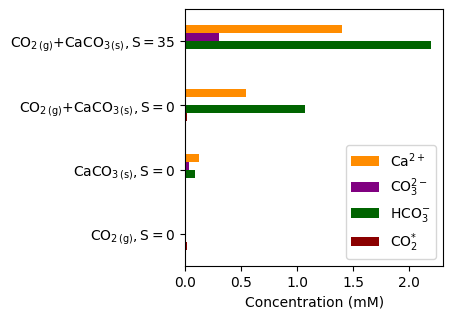

In [15]:
#CO2 and carbonate correct for salinity system
Kh=3.40e-2      #Kh  = co2/atm      = x[1]/x[0]
Ka1=4.46e-7     #Ka1 = hdr*bct/co2  = x[4]*x[2]/x[1]
Ka2=4.69e-11    #Ka2 = hdr*car/bct  = x[4]*x[3]/x[2]
Kw=1.0e-14      #Kw  = hdr*hox      = x[4]*x[5]
Ksp=4.6e-9      #Ksp = cal*car      = x[6]*x[3]

print("K0 = "+str(Kh))
print("Ka1 = "+str(Ka1))
print("Ka2 = "+str(Ka2))
print("Kw = "+str(Kw))
print("Ksp calcite = "+str(Ksp))

temp=25+273.15
sal=35
flgCorrectForTempAndSal=True

if flgCorrectForTempAndSal==True:
    Kh=np.exp(93.4517*(100/temp)-60.2409+23.3585*np.log(temp/100)+sal*(0.023517-0.023656*(temp/100)+0.004736*(temp/100)**2))
    print("Kh = "+str(Kh)+", change = "+str((Kh-3.40e-2)/3.40e-2*100)+"%")
    Ka1=10**( (-3633.86/temp) + 61.2172 - 9.67770*np.log(temp) + 0.011555*sal - 0.0001152*sal**2 )
    #print(-np.log10(eqK1))
    print("Ka1 = "+str(Ka1)+", change = "+str((Ka1-4.46e-7)/4.46e-7*100)+"%")
    Ka2=10**( (-471.78/temp) - 25.9290 + 3.16967*np.log(temp) + 0.01781*sal - 0.0001122*sal**2 )
    #print(-np.log10(eqK2))
    print("Ka2 = "+str(Ka2)+", change = "+str((Ka2-4.69e-11)/4.69e-11*100)+"%")
    Kw=np.exp(-13847.26/temp+148.9652-23.6531*np.log(temp)+(118.67/temp-5.977+1.0495*np.log(temp))*sal**(1/2)-0.01615*sal)
    print("Kw = "+str(Kw)+", change = "+str((Kw-1.0e-14)/1.0e-14*100)+"%")
    Ksp=10**( -171.9065 - 0.077993*temp + 2839.319/temp + 71.595*np.log10(temp) + (-0.77712+0.0028426*temp+178.34/temp)*sal**(1/2) - 0.07711*sal + 0.0041249*sal**1.5 )
    print("Ksp calcite = "+str(Ksp)+", change = "+str((Ksp-4.6e-9)/4.6e-9*100)+"%")
    KspPrime=Ka1*Ksp/Ka2
    print("Ksp prime = "+str(KspPrime))

def FunCO2Car(x):
    f0=x[1]-(Kh)*(x[0])                         #Henry's Law
    f1=x[4]*x[2]-(Ka1*x[1])                     #Ka1 of dissolved CO2 to bicarbonate
    f2=x[4]*x[3]-(Ka2*x[2])                     #Ka2 of bicarbonate to carbonate
    f3=x[4]*x[5]-Kw                             #dissociation of water
    f4=x[6]*x[3]-Ksp                            #dissociation of calcium carbonate
    f5=x[2]+2*x[3]+x[5]-x[4]-2*x[6]             #charge balance
    f6=x[0]-atm                                 #atmospheric CO2 is fixed, mass balance doesn't apply (carbon can come from atmospheric CO2 or calcium carbonate)
    return np.array([f0,f1,f2,f3,f4,f5,f6])

ppm=420                                     #mixing ratio of CO2 in ppmv
atm=ppm/1.0e6
#initial guesses
co2=atm*Kh                                  #calculates the initial dissolved CO2 using Henry's Law constant
cal=np.sqrt(Ksp)                            #initial guess for calcium concentration based on Ksp
car=np.sqrt(Ksp)                            #initial guess for carbonate concentration based on Ksp
bct=np.sqrt(Ka1*co2) + np.sqrt(car*Kw/Ka2)  #initial guess for bicarbonate concentration based on sum of CO2 only and calcium carbonate
hdr=10**-(8)                                #initial guess for hydronium concentration based on ocean pH
hox=Kw/hdr                                  #initial guess for hydroxide based on hydronium
x0=np.array([atm,co2,bct,car,hdr,hox,cal])
dfAll.loc["SAL_TMP Start"]=x0
x=fsolve(FunCO2Car,x0)
dfResults.loc["CO2+CC, S=35g/kg"]=x
res1=least_squares(FunCO2Car,x0,bounds=(0, 0.1),gtol=None,ftol=None,xtol=2.5e-16,max_nfev=10000,method="dogbox",jac='3-point') #the fsolve function takes the array of 5 equations and solves for the 5 unknowns using the x0 array as initial guesses
x=res1.x
print(res1.message)
print(res1.optimality)
#dfResults.loc["SAL_TMP Opt ls"]=x
#dfResults[['co2','bct','car','cal']].plot.barh(color=chartColors,rot=0)
#plt.legend(loc='lower right',reverse=True)

#chartColors = ['#0771eb','#ce59bf','#fc657d','#ee9550']
#from https://www.learnui.design/tools/data-color-picker.html#palette

plt.rcParams["figure.dpi"] = 100
dfFigure=pd.DataFrame()
dfFigure[['carbon dioxide','bicarbonate','carbonate','calcium']]=dfResults[['co2','bct','car','cal']]*1000
ax = dfFigure.plot(kind='barh', color=chartColors, rot=0, xlabel='Concentration (mM)', figsize=(3.33,3.33))
ax.legend(['$\mathrm{CO^{*}_{2}}$','$\mathrm{HCO_3^{-}}$','$\mathrm{CO_3^{2-}}$','$\mathrm{Ca^{2+}}$'],loc='lower right',reverse=True)
ax.set_yticklabels(['$\mathrm{CO_{2 \, (g)},S=0,25^oC}$','$\mathrm{CaCO_{3 \, (s)},S=0,25^oC}$','$\mathrm{CO_{2 \, (g)}}$+$\mathrm{CaCO_{3 \, (s)},S=0,25^oC}$','$\mathrm{CO_{2 \, (g)}}$+$\mathrm{CaCO_{3 \, (s)},S=35,20^oC}$'])
ax.set_yticklabels(['$\mathrm{CO_{2 \, (g)},S=0}$','$\mathrm{CaCO_{3 \, (s)},S=0}$','$\mathrm{CO_{2 \, (g)}}$+$\mathrm{CaCO_{3 \, (s)},S=0}$','$\mathrm{CO_{2 \, (g)}}$+$\mathrm{CaCO_{3 \, (s)},S=35}$'])
dfResults

K0 = 0.034
Ka1 = 4.46e-07
Ka2 = 4.69e-11
Kw = 1e-14
Ksp calcite = 4.6e-09
Kh = 0.03272480681212185, change = -3.7505681996416214%
Ka1 = 1.2842182077039706e-06, change = 187.94130217577813%
Ka2 = 8.983658727790542e-10, change = 1815.4922660534205%
Kw = 3.817821133752885e-14, change = 281.7821133752885%
Ksp calcite = 4.3000351488246635e-07, change = 9247.902497444922%
Ksp prime = 0.0006146920312995707
`xtol` termination condition is satisfied.
2.0437821772809708e-23


,atm,co2,bct,car,hdr,hox,cal
CO2 Only,4.250000e-04,1.445000e-05,0.000003,4.682561e-11,2.540657e-06,3.935990e-09,-5.396351e-34
CC Only,6.495223e-07,2.208376e-08,0.000088,3.673172e-05,1.121424e-10,8.917236e-05,1.252324e-04
CO2+CC,4.200000e-04,1.428000e-05,0.001071,8.444724e-06,5.947374e-09,1.681414e-06,5.447188e-04
"CO2+CC, S=35g/kg",4.200000e-04,1.374442e-05,0.002385,2.895950e-04,7.399693e-09,5.159432e-06,1.484844e-03


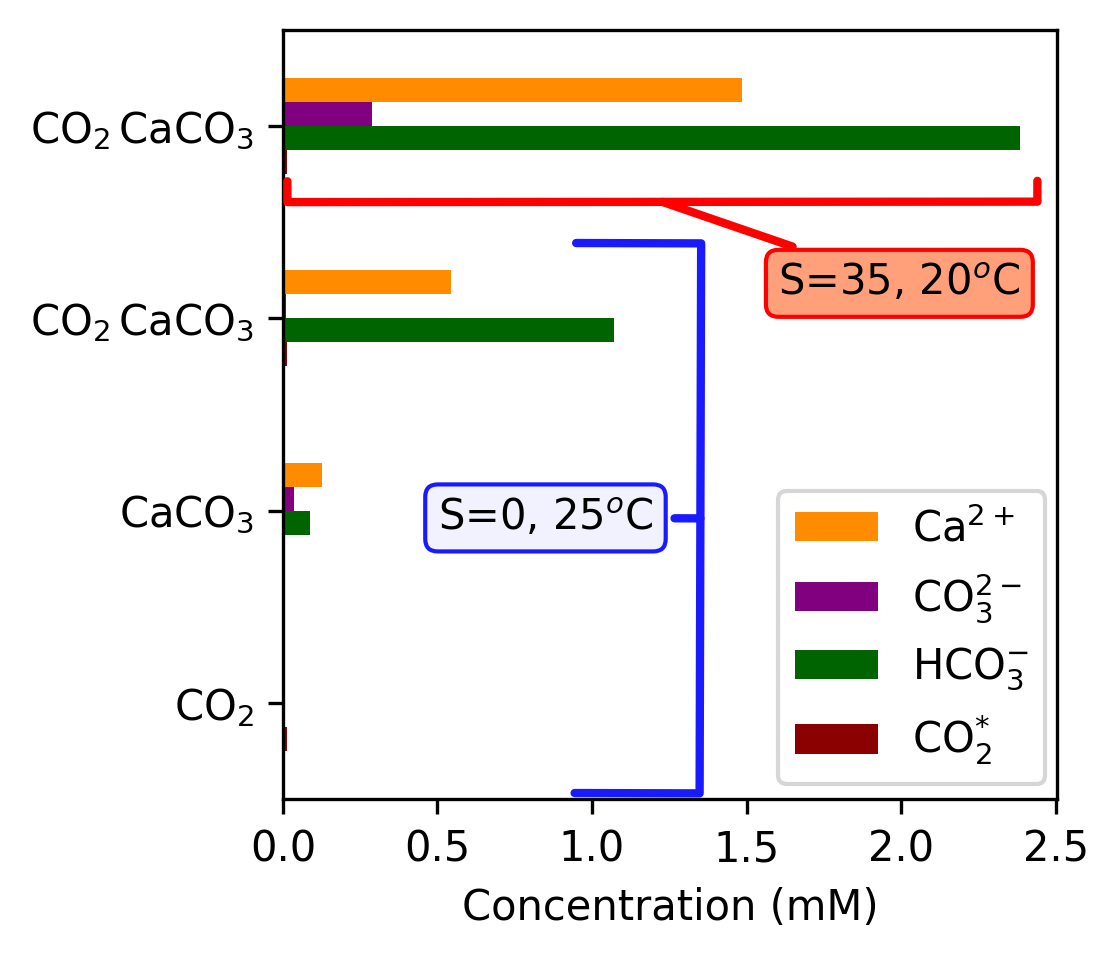

In [16]:
#CO2 and carbonate correct for salinity system
Kh=3.40e-2      #Kh  = co2/atm      = x[1]/x[0]
Ka1=4.46e-7     #Ka1 = hdr*bct/co2  = x[4]*x[2]/x[1]
Ka2=4.69e-11    #Ka2 = hdr*car/bct  = x[4]*x[3]/x[2]
Kw=1.0e-14      #Kw  = hdr*hox      = x[4]*x[5]
Ksp=4.6e-9      #Ksp = cal*car      = x[6]*x[3]

print("K0 = "+str(Kh))
print("Ka1 = "+str(Ka1))
print("Ka2 = "+str(Ka2))
print("Kw = "+str(Kw))
print("Ksp calcite = "+str(Ksp))

temp=20+273.15
sal=35
flgCorrectForTempAndSal=True

if flgCorrectForTempAndSal==True:
    Kh=np.exp(93.4517*(100/temp)-60.2409+23.3585*np.log(temp/100)+sal*(0.023517-0.023656*(temp/100)+0.004736*(temp/100)**2))
    print("Kh = "+str(Kh)+", change = "+str((Kh-3.40e-2)/3.40e-2*100)+"%")
    Ka1=10**( (-3633.86/temp) + 61.2172 - 9.67770*np.log(temp) + 0.011555*sal - 0.0001152*sal**2 )
    #print(-np.log10(eqK1))
    print("Ka1 = "+str(Ka1)+", change = "+str((Ka1-4.46e-7)/4.46e-7*100)+"%")
    Ka2=10**( (-471.78/temp) - 25.9290 + 3.16967*np.log(temp) + 0.01781*sal - 0.0001122*sal**2 )
    #print(-np.log10(eqK2))
    print("Ka2 = "+str(Ka2)+", change = "+str((Ka2-4.69e-11)/4.69e-11*100)+"%")
    Kw=np.exp(-13847.26/temp+148.9652-23.6531*np.log(temp)+(118.67/temp-5.977+1.0495*np.log(temp))*sal**(1/2)-0.01615*sal)
    print("Kw = "+str(Kw)+", change = "+str((Kw-1.0e-14)/1.0e-14*100)+"%")
    Ksp=10**( -171.9065 - 0.077993*temp + 2839.319/temp + 71.595*np.log10(temp) + (-0.77712+0.0028426*temp+178.34/temp)*sal**(1/2) - 0.07711*sal + 0.0041249*sal**1.5 )
    print("Ksp calcite = "+str(Ksp)+", change = "+str((Ksp-4.6e-9)/4.6e-9*100)+"%")
    KspPrime=Ka1*Ksp/Ka2
    print("Ksp prime = "+str(KspPrime))

def FunCO2Car(x):
    f0=x[1]-(Kh)*(x[0])                         #Henry's Law
    f1=x[4]*x[2]-(Ka1*x[1])                     #Ka1 of dissolved CO2 to bicarbonate
    f2=x[4]*x[3]-(Ka2*x[2])                     #Ka2 of bicarbonate to carbonate
    f3=x[4]*x[5]-Kw                             #dissociation of water
    f4=x[6]*x[3]-Ksp                            #dissociation of calcium carbonate
    f5=x[2]+2*x[3]+x[5]-x[4]-2*x[6]             #charge balance
    f6=x[0]-atm                                 #atmospheric CO2 is fixed, mass balance doesn't apply (carbon can come from atmospheric CO2 or calcium carbonate)
    return np.array([f0,f1,f2,f3,f4,f5,f6])

ppm=420                                     #mixing ratio of CO2 in ppmv
atm=ppm/1.0e6
#initial guesses
co2=atm*Kh                                  #calculates the initial dissolved CO2 using Henry's Law constant
cal=np.sqrt(Ksp)                            #initial guess for calcium concentration based on Ksp
car=np.sqrt(Ksp)                            #initial guess for carbonate concentration based on Ksp
bct=np.sqrt(Ka1*co2) + np.sqrt(car*Kw/Ka2)  #initial guess for bicarbonate concentration based on sum of CO2 only and calcium carbonate
hdr=10**-(8)                                #initial guess for hydronium concentration based on ocean pH
hox=Kw/hdr                                  #initial guess for hydroxide based on hydronium
x0=np.array([atm,co2,bct,car,hdr,hox,cal])
dfAll.loc["SAL_TMP Start"]=x0
x=fsolve(FunCO2Car,x0)
dfResults.loc["CO2+CC, S=35g/kg"]=x
res1=least_squares(FunCO2Car,x0,bounds=(0, 0.1),gtol=None,ftol=None,xtol=2.5e-16,max_nfev=10000,method="dogbox",jac='3-point') #the fsolve function takes the array of 5 equations and solves for the 5 unknowns using the x0 array as initial guesses
x=res1.x
print(res1.message)
print(res1.optimality)
#dfResults.loc["SAL_TMP Opt ls"]=x
#dfResults[['co2','bct','car','cal']].plot.barh(color=chartColors,rot=0)
#plt.legend(loc='lower right',reverse=True)

#chartColors = ['#0771eb','#ce59bf','#fc657d','#ee9550']
#from https://www.learnui.design/tools/data-color-picker.html#palette

plt.rcParams["figure.dpi"] = 300
dfFigure=pd.DataFrame()
dfFigure[['carbon dioxide','bicarbonate','carbonate','calcium']]=dfResults[['co2','bct','car','cal']]*1000
ax = dfFigure.plot(kind='barh', color=chartColors, rot=0, xlabel='Concentration (mM)', figsize=(3.33,3.33))
ax.legend(['$\mathrm{CO^{*}_{2}}$','$\mathrm{HCO_3^{-}}$','$\mathrm{CO_3^{2-}}$','$\mathrm{Ca^{2+}}$'],loc=(0.64,0.02),reverse=True)
#ax.set_yticklabels(['$\mathrm{CO_{2 \, (g)},S=0,25^oC}$','$\mathrm{CaCO_{3 \, (s)},S=0,25^oC}$','$\mathrm{CO_{2 \, (g)}}$+$\mathrm{CaCO_{3 \, (s)},S=0,25^oC}$','$\mathrm{CO_{2 \, (g)}}$+$\mathrm{CaCO_{3 \, (s)},S=35,20^oC}$'])
ax.set_yticklabels(['$\mathrm{CO_{2}}$','$\mathrm{CaCO_{3}}$','$\mathrm{CO_{2}}\,\mathrm{CaCO_{3}}$','$\mathrm{CO_{2}}\,\mathrm{CaCO_{3}}$'])

ax.annotate("S=0, $25^o$C",
            xy=(0.55, 3/8-0.01), xycoords='axes fraction',
            xytext=(0.2, 3/8-0.025), textcoords='axes fraction',
            arrowprops=dict(
                    arrowstyle="-[,widthB=6.6, lengthB=-3, angleB=0",
                    color=(0.1,0.1,1),
                    lw=2,
            ),
            bbox={'boxstyle':'round', 'edgecolor':(0.1,0.1,1),'facecolor':(0.95,0.95,1)}
            )

ax.annotate("S=35, $20^o$C",
            xy=(.48, 6/8+0.03), xycoords='axes fraction',
            xytext=(0.64, 5/8+0.03), textcoords='axes fraction',
            arrowprops=dict(
                    arrowstyle="-[,widthB=9, lengthB=0.5, angleB=-71",
                    color="red",
                    lw=2,
            ),
            bbox={'boxstyle':'round', 'edgecolor':'red','facecolor':'lightsalmon'}
            )
dfResults

In [17]:
#CO2 and carbonate correct for salinity system
Kh=3.40e-2      #Kh  = co2/atm      = x[1]/x[0]
Ka1=4.46e-7     #Ka1 = hdr*bct/co2  = x[4]*x[2]/x[1]
Ka2=4.69e-11    #Ka2 = hdr*car/bct  = x[4]*x[3]/x[2]
Kw=1.0e-14      #Kw  = hdr*hox      = x[4]*x[5]
Ksp=4.6e-9      #Ksp = cal*car      = x[6]*x[3]

print("K0 = "+str(Kh))
print("Ka1 = "+str(Ka1))
print("Ka2 = "+str(Ka2))
print("Kw = "+str(Kw))
print("Ksp calcite = "+str(Ksp))

temp=20+273.15
sal=35
flgCorrectForTempAndSal=True

if flgCorrectForTempAndSal==True:
    Kh=np.exp(93.4517*(100/temp)-60.2409+23.3585*np.log(temp/100)+sal*(0.023517-0.023656*(temp/100)+0.004736*(temp/100)**2))
    print("Kh = "+str(Kh)+", change = "+str((Kh-3.40e-2)/3.40e-2*100)+"%")
    Ka1=10**( (-3633.86/temp) + 61.2172 - 9.67770*np.log(temp) + 0.011555*sal - 0.0001152*sal**2 )
    #print(-np.log10(eqK1))
    print("Ka1 = "+str(Ka1)+", change = "+str((Ka1-4.46e-7)/4.46e-7*100)+"%")
    Ka2=10**( (-471.78/temp) - 25.9290 + 3.16967*np.log(temp) + 0.01781*sal - 0.0001122*sal**2 )
    #print(-np.log10(eqK2))
    print("Ka2 = "+str(Ka2)+", change = "+str((Ka2-4.69e-11)/4.69e-11*100)+"%")
    Kw=np.exp(-13847.26/temp+148.9652-23.6531*np.log(temp)+(118.67/temp-5.977+1.0495*np.log(temp))*sal**(1/2)-0.01615*sal)
    print("Kw = "+str(Kw)+", change = "+str((Kw-1.0e-14)/1.0e-14*100)+"%")
    Ksp=10**( -171.9065 - 0.077993*temp + 2839.319/temp + 71.595*np.log10(temp) + (-0.77712+0.0028426*temp+178.34/temp)*sal**(1/2) - 0.07711*sal + 0.0041249*sal**1.5 )
    print("Ksp calcite = "+str(Ksp)+", change = "+str((Ksp-4.6e-9)/4.6e-9*100)+"%")
    KspPrime=Ka1*Ksp/Ka2
    print("Ksp prime = "+str(KspPrime))

def FunCO2Car(x):
    f0=x[1]-(Kh)*(x[0])                         #Henry's Law
    f1=x[4]*x[2]-(Ka1*x[1])                     #Ka1 of dissolved CO2 to bicarbonate
    f2=x[4]*x[3]-(Ka2*x[2])                     #Ka2 of bicarbonate to carbonate
    f3=x[4]*x[5]-Kw                             #dissociation of water
    f4=x[6]*x[3]-Ksp                            #dissociation of calcium carbonate
    f5=x[2]+2*x[3]+x[5]-x[4]-2*x[6]             #charge balance (calcium is included but should not be present in CO2 only system)
    f6=x[0]-atm                                 #mass balance doesn't apply (carbon can come from atmospheric CO2 or calcium carbonate), atmospheric CO2 is fixed
    return np.array([f0,f1,f2,f3,f4,f5,f6])

ppmList=np.arange(100,1010,10)                 #mixing ratio of CO2 in ppmv
dfRangeFsolve=pd.DataFrame(index=ppmList,columns=["atm","co2","bct","car","hdr","hox","cal"])
dfRangeLS=pd.DataFrame(index=ppmList,columns=["atm","co2","bct","car","hdr","hox","cal"])
#initial guesses
for ppm,index in zip(ppmList,range(len(ppmList))):
  if index==0:
    #x0LS=dfResults.loc["SAL_TMP Opt ls"]=x
    #x0LS=dfResults.loc["SAL_TMP Opt ls"]=x
    atm=ppm/1.0e6
    co2=atm*Kh                                  #calculates the initial dissolved CO2 using Henry's Law constant
    cal=np.sqrt(Ksp)                            #initial guess for calcium concentration based on Ksp
    car=np.sqrt(Ksp)                            #initial guess for carbonate concentration based on Ksp
    bct=np.sqrt(Ka1*co2) + np.sqrt(car*Kw/Ka2)  #initial guess for bicarbonate concentration based on sum of CO2 only and calcium carbonate
    hdr=10**-(8)                                #initial guess for hydronium concentration based on ocean pH
    hox=Kw/hdr                                  #initial guess for hydroxide based on hydronium
    x0FS=np.array([atm,co2,bct,car,hdr,hox,cal])
    x0LS=np.array([atm,co2,bct,car,hdr,hox,cal])
  else:
    atm=ppm/1.0e6
    x0FS=np.array(dfRangeFsolve.iloc[index-1,:],dtype=float)
    x0LS=np.array(dfRangeLS.iloc[index-1,:],dtype=float)
  xFS=fsolve(FunCO2Car,x0FS)
  dfRangeFsolve.iloc[index,:]=xFS
  res1=least_squares(FunCO2Car,x0LS,bounds=(0, 0.1),gtol=None,ftol=None,xtol=2.5e-16,max_nfev=100000,method="dogbox",jac='3-point')
  xLS=res1.x
  if res1.message!='`xtol` termination condition is satisfied.':
    print(str(ppm)+" ppm, "+res1.message+" opt="+str(res1.optimality))
  dfRangeLS.iloc[index,:]=xLS
dfRangeLS

K0 = 0.034
Ka1 = 4.46e-07
Ka2 = 4.69e-11
Kw = 1e-14
Ksp calcite = 4.6e-09
Kh = 0.03272480681212185, change = -3.7505681996416214%
Ka1 = 1.2842182077039706e-06, change = 187.94130217577813%
Ka2 = 8.983658727790542e-10, change = 1815.4922660534205%
Kw = 3.817821133752885e-14, change = 281.7821133752885%
Ksp calcite = 4.3000351488246635e-07, change = 9247.902497444922%
Ksp prime = 0.0006146920312995707


,atm,co2,bct,car,hdr,hox,cal
100,0.0001,0.000003,0.001362,0.000397,0.0,0.000012,0.001084
110,0.00011,0.000004,0.001416,0.00039,0.0,0.000012,0.001104
120,0.00012,0.000004,0.001467,0.000383,0.0,0.000011,0.001122
130,0.00013,0.000004,0.001515,0.000377,0.0,0.000011,0.00114
140,0.00014,0.000005,0.00156,0.000372,0.0,0.00001,0.001157
...,...,...,...,...,...,...,...
960,0.00096,0.000031,0.003231,0.000232,0.0,0.000003,0.00185
970,0.00097,0.000032,0.003243,0.000232,0.0,0.000003,0.001855
980,0.00098,0.000032,0.003255,0.000231,0.0,0.000003,0.00186
990,0.00099,0.000032,0.003267,0.00023,0.0,0.000003,0.001866


In [18]:
atmPre=280/1e6
hdrPre=np.array(dfRangeLS['hdr'][dfRangeLS['atm']==atmPre],dtype='float')
pHpre=-np.log10(hdrPre[0])
print('{:.2f}'.format(pHpre))
ppmNow=420


8.24


<ipython-input-19-5407e272fce1>:69: UserWarning: The figure layout has changed to tight
  fig2.tight_layout()


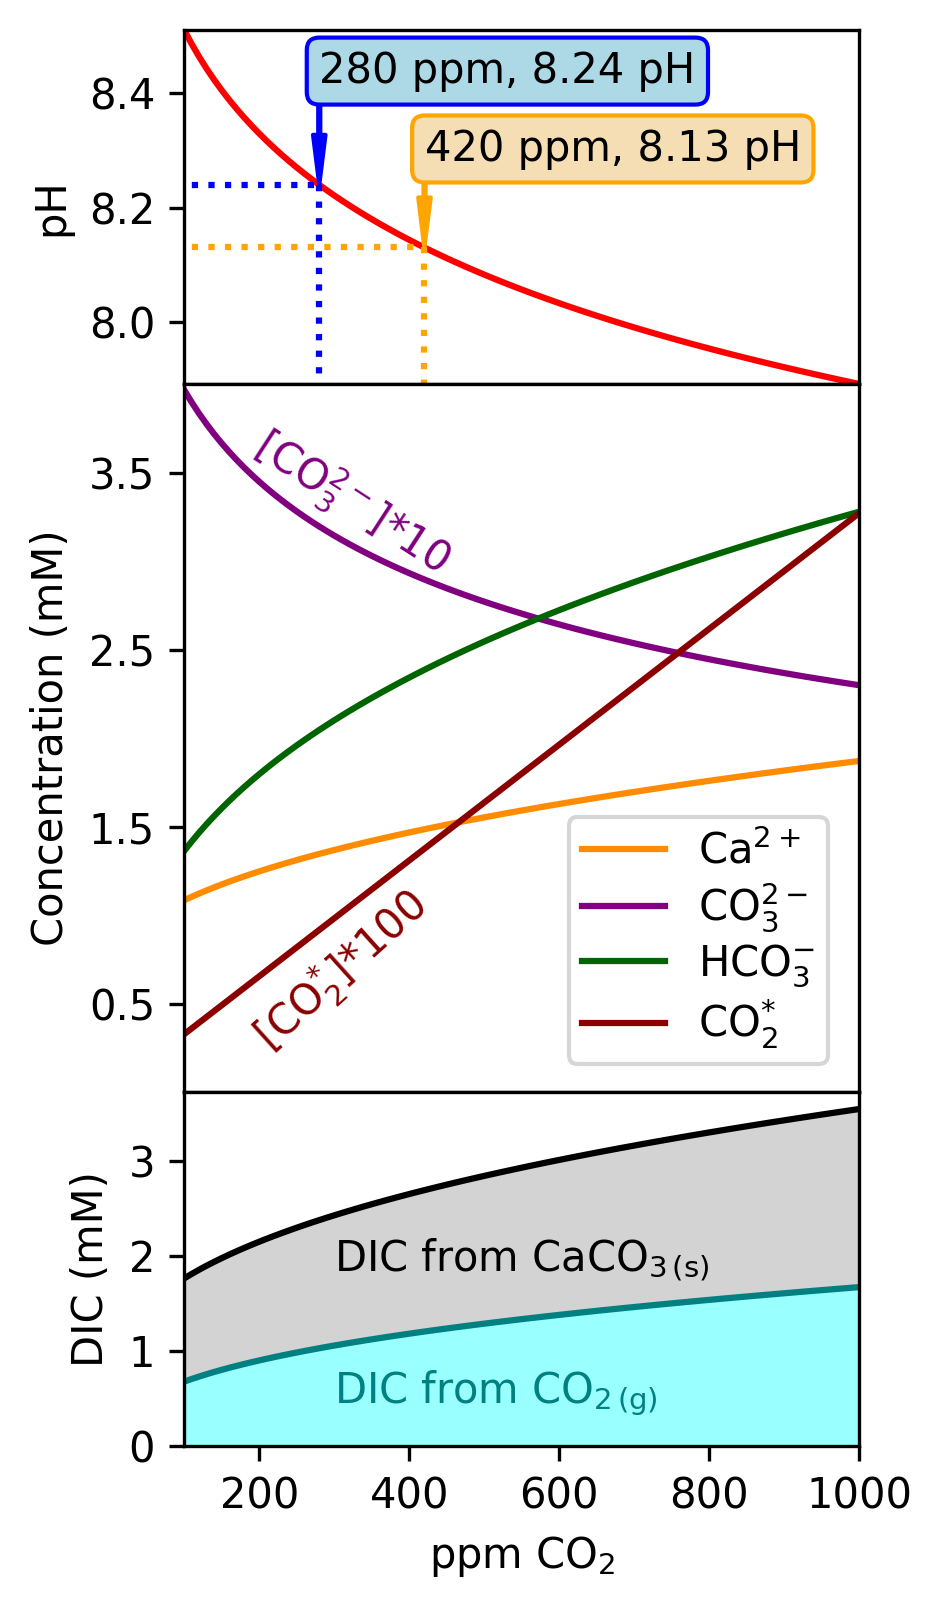

In [19]:

pH=-np.log10(np.array(dfRangeLS['hdr'],dtype='float'))
dicT=np.array(dfRangeLS['car']+dfRangeLS['bct']+dfRangeLS['co2'],dtype='float')*1000
dicL=np.array(dfRangeLS['cal'],dtype='float')*1000
dicA=dicT-dicL

from matplotlib.gridspec import GridSpec
colors=["Teal","DarkRed","DarkGreen","Purple","Red","Blue","DarkOrange"]

fig2 = plt.figure(layout="constrained",figsize=(3.33,5.5),dpi=300)
gs = GridSpec(4, 1, figure=fig2)
gs.update(wspace=0.0, hspace=0.0)
ax_pH = fig2.add_subplot(gs[0, 0])
ax_M = fig2.add_subplot(gs[1:3, 0])
ax_DIC = fig2.add_subplot(gs[3, 0])

ax_pH.plot(ppmList,pH,color=colors[4])
ax_pH.hlines(-np.log10(np.array(dfRangeLS.loc[420,'hdr'],dtype='float')),0,420,linestyles='dotted',colors='orange')
ax_pH.vlines(420,-np.log10(np.array(dfRangeLS.loc[420,'hdr'],dtype='float')),np.min(pH),linestyles='dotted',colors='orange')
ax_pH.hlines(-np.log10(np.array(dfRangeLS.loc[280,'hdr'],dtype='float')),0,280,linestyles='dotted',colors='blue')
ax_pH.vlines(280,-np.log10(np.array(dfRangeLS.loc[280,'hdr'],dtype='float')),np.min(pH),linestyles='dotted',colors='blue')
ax_pH.set_ylim([np.min(pH),np.max(pH)])
ax_pH.set_xlim([np.min(ppmList),np.max(ppmList)])
ax_pH.tick_params(bottom=False, labelbottom=False)
ax_pH.set_ylabel(r"pH")
ppmPre=280
atmPre=ppmPre/1e6
hdrPre=np.array(dfRangeLS['hdr'][dfRangeLS['atm']==atmPre],dtype='float')
pHpre=-np.log10(hdrPre[0])
ax_pH.annotate(str(ppmPre)+' ppm, '+'{:.2f}'.format(pHpre)+' pH',
            xy=(ppmPre, pHpre), xycoords='data',                           #"data' is the default unit for graph coodinates
            xytext=(0.2, 0.85), textcoords='axes fraction',                 #'axes fraction' is (x,y) lower left is (0,0) upper right is (1,1)
            arrowprops={'color': 'blue', 'width':0.5, 'headwidth':3},
            bbox={'boxstyle':'round', 'edgecolor':'blue','facecolor':'lightBlue'}
            )
ppmPre=420
atmPre=ppmPre/1e6
hdrPre=np.array(dfRangeLS['hdr'][dfRangeLS['atm']==atmPre],dtype='float')
pHpre=-np.log10(hdrPre[0])
ax_pH.annotate(str(ppmPre)+' ppm, '+'{:.2f}'.format(pHpre)+' pH',
            xy=(ppmPre, pHpre), xycoords='data',                           #"data' is the default unit for graph coodinates
            xytext=(0.356, 0.63), textcoords='axes fraction',                 #'axes fraction' is (x,y) lower left is (0,0) upper right is (1,1)
            arrowprops={'color': 'orange', 'width':0.5, 'headwidth':3},
            bbox={'boxstyle':'round', 'edgecolor':'orange','facecolor':'wheat'}
            )

ax_M.plot(ppmList,dfRangeLS['cal']*1000,color=colors[6],label="cal")
ax_M.plot(ppmList,dfRangeLS['car']*10000,color=colors[3],label="car")
ax_M.text(180, 3.8, "[$\mathrm{CO_3^{2-}}$]*10",color=colors[3],ha='left', va='top', rotation=-33)
ax_M.plot(ppmList,dfRangeLS['bct']*1000,color=colors[2],label="bct")
ax_M.plot(ppmList,dfRangeLS['co2']*100000,color=colors[1],label="co2")
ax_M.text(180, 1.2, "[$\mathrm{CO_2^{*}}$]*100",color=colors[1],ha='left', va='top', rotation=42)
ax_M.set_xlim([np.min(ppmList),np.max(ppmList)])
ax_M.set_ylabel("Concentration (mM)")
ax_M.set_ylim([0,4])
ax_M.set_yticks([0.5,1.5,2.5,3.5])
ax_M.tick_params(bottom=False, labelbottom=False)
ax_M.legend(['$\mathrm{Ca^{2+}}$','$\mathrm{CO_3^{2-}}$','$\mathrm{HCO_3^{-}}$','$\mathrm{CO^{*}_{2}}$'],loc=(0.57,0.04),borderpad=0.3,labelspacing=0.2)

ax_DIC.plot(ppmList,dicT,color="k")
ax_DIC.plot(ppmList,dicA,color="teal")
ax_DIC.fill_between(ppmList, dicT, dicA, color="lightgrey")
ax_DIC.fill_between(ppmList, dicA, 0, color=[.6,1,1])
ax_DIC.text(300, 1.7, "DIC from $\mathrm{CaCO_{3 \, (s)}}$",color='black',ha='left', va='bottom', rotation=0)
ax_DIC.text(300, .3, "DIC from $\mathrm{CO_{2 \, (g)}}$",color='teal',ha='left', va='bottom', rotation=0)
ax_DIC.set_xlim([np.min(ppmList),np.max(ppmList)])
ax_DIC.set_ylim([0,np.max(dicT)*1.05])
ax_DIC.set_ylabel(r"DIC (mM)")
ax_DIC.set_xlabel("ppm $\mathrm {CO_2}$")
fig2.tight_layout()



In [20]:
def Carbonic_pKas(t,s):
  # from https://www.sciencedirect.com/science/article/abs/pii/S0304420305001921
  pKa1n=-126.34048+6320.813/t+19.568224*np.log(t)
  a1=13.4191*s**0.5+0.0331*s-5.33e-5*s**2
  b1=-530.123*s**0.5-6.103*s
  c1=-2.06950*s**0.5
  pka1=a1+b1/t+c1*np.log(t)+pKa1n

  pKa2n=-90.18333+5143.692/t+14.613358*np.log(t)
  a2=21.0894*s**0.5+.1248*s-3.687e-4*s**2
  b2=-772.483*s**0.5-20.051*s
  c2=-3.3336*s**0.5
  pka2=a2+b2/t+c2*np.log(t)+pKa2n
  return [pka1,pka2]

def Davies(i,z):
  # https://en.wikipedia.org/wiki/Davies_equation
  pAlpha=0.5*z**2*(np.sqrt(i)/(1+np.sqrt(i))-0.3*i)
  return 10**-pAlpha


pka1,pka2=Carbonic_pKas(25+273.15,0)
print("pKa1 = "+str(pka1)+", Ka1 = "+str(10**-pka1))
print("pKa2 = "+str(pka2)+", Ka2 = "+str(10**-pka2))
actCoeff=Davies(0.71,2)
print("Activity coeff of +2= "+str(actCoeff))
actCoeff=Davies(0.71,1)
print("Activity coeff of +1= "+str(actCoeff))


pKa1 = 6.351479474463076, Ka1 = 4.4516450169651834e-07
pKa2 = 10.329718047170417, Ka2 = 4.6803890306795246e-11
Activity coeff of +2= 0.32464891033966903
Activity coeff of +1= 0.7548375344014585


In [21]:
#CO2 and carbonate ocean range of temps
def FunCO2Car(x):
    f0=x[1]-(Kh)*(x[0])                         #Henry's Law
    f1=x[4]*x[2]-(Ka1*x[1])                     #Ka1 of dissolved CO2 to bicarbonate
    f2=x[4]*x[3]-(Ka2*x[2])                     #Ka2 of bicarbonate to carbonate
    f3=x[4]*x[5]-Kw                             #dissociation of water
    f4=x[6]*x[3]-Ksp                            #dissociation of calcium carbonate
    f5=x[2]+2*x[3]+x[5]-x[4]-2*x[6]             #charge balance (calcium is included but should not be present in CO2 only system)
    f6=x[0]-atm                                 #mass balance doesn't apply (carbon can come from atmospheric CO2 or calcium carbonate), atmospheric CO2 is fixed
    return np.array([f0,f1,f2,f3,f4,f5,f6])

ppm=420
sal=35
flgCorrectForTempAndSal=True
tempList=np.arange(0,30,1)
dfRangeTemp=pd.DataFrame(index=tempList,columns=["atm","co2","bct","car","hdr","hox","cal","Kh","Ka1","Ka2","Kw","Ksp"])
for tempC,index in zip(tempList,range(len(tempList))):
    temp=tempC+273.15
    Kh=np.exp(93.4517*(100/temp)-60.2409+23.3585*np.log(temp/100)+sal*(0.023517-0.023656*(temp/100)+0.004736*(temp/100)**2))
    dfRangeTemp.iloc[index,7]=Kh
    Ka1=10**( (-3633.86/temp) + 61.2172 - 9.67770*np.log(temp) + 0.011555*sal - 0.0001152*sal**2 )
    dfRangeTemp.iloc[index,8]=Ka1
    Ka2=10**( (-471.78/temp) - 25.9290 + 3.16967*np.log(temp) + 0.01781*sal - 0.0001122*sal**2 )
    dfRangeTemp.iloc[index,9]=Ka2
    Kw=np.exp(-13847.26/temp+148.9652-23.6531*np.log(temp)+(118.67/temp-5.977+1.0495*np.log(temp))*sal**(1/2)-0.01615*sal)
    dfRangeTemp.iloc[index,10]=Kw
    Ksp=10**( -171.9065 - 0.077993*temp + 2839.319/temp + 71.595*np.log10(temp) + (-0.77712+0.0028426*temp+178.34/temp)*sal**(1/2) - 0.07711*sal + 0.0041249*sal**1.5 )
    dfRangeTemp.iloc[index,11]=Ksp
    if index==0:
      atm=ppm/1.0e6
      co2=atm*Kh                                  #calculates the initial dissolved CO2 using Henry's Law constant
      cal=np.sqrt(Ksp)                            #initial guess for calcium concentration based on Ksp
      car=np.sqrt(Ksp)                            #initial guess for carbonate concentration based on Ksp
      bct=np.sqrt(Ka1*co2) + np.sqrt(car*Kw/Ka2)  #initial guess for bicarbonate concentration based on sum of CO2 only and calcium carbonate
      hdr=10**-(8)                                #initial guess for hydronium concentration based on ocean pH
      hox=Kw/hdr                                  #initial guess for hydroxide based on hydronium
      x0=np.array([atm,co2,bct,car,hdr,hox,cal])
    else:
      atm=ppm/1.0e6
      x0=np.array(dfRangeTemp.iloc[index-1,0:7],dtype=float)
    res1=least_squares(FunCO2Car,x0,bounds=(0, 1),gtol=None,ftol=None,xtol=2.5e-16,max_nfev=100000,method="dogbox",jac='3-point')
    x=res1.x
    if res1.message!='`xtol` termination condition is satisfied.':
      print(str(ppm)+" ppm, "+res1.message+" opt="+str(res1.optimality))
    dfRangeTemp.iloc[index,0:7]=x
dfRangeTemp

,atm,co2,bct,car,hdr,hox,cal,Kh,Ka1,Ka2,Kw,Ksp
0,0.00042,0.000027,0.003356,0.000225,0.0,0.000001,0.001904,0.063404,0.000001,0.0,0.0,0.0
1,0.00042,0.000026,0.003298,0.000229,0.0,0.000001,0.001878,0.061001,0.000001,0.0,0.0,0.0
2,0.00042,0.000025,0.003241,0.000232,0.0,0.000001,0.001853,0.058726,0.000001,0.0,0.0,0.0
3,0.00042,0.000024,0.003185,0.000235,0.0,0.000001,0.001828,0.05657,0.000001,0.0,0.0,0.0
4,0.00042,0.000023,0.00313,0.000239,0.0,0.000001,0.001804,0.054527,0.000001,0.0,0.0,0.0
5,0.00042,0.000022,0.003077,0.000242,0.0,0.000001,0.001781,0.05259,0.000001,0.0,0.0,0.0
6,0.00042,0.000021,0.003024,0.000245,0.0,0.000001,0.001758,0.050753,0.000001,0.0,0.0,0.0
7,0.00042,0.000021,0.002973,0.000249,0.0,0.000002,0.001736,0.049008,0.000001,0.0,0.0,0.0
8,0.00042,0.00002,0.002922,0.000252,0.0,0.000002,0.001714,0.047351,0.000001,0.0,0.0,0.0
9,0.00042,0.000019,0.002873,0.000255,0.0,0.000002,0.001692,0.045777,0.000001,0.0,0.0,0.0


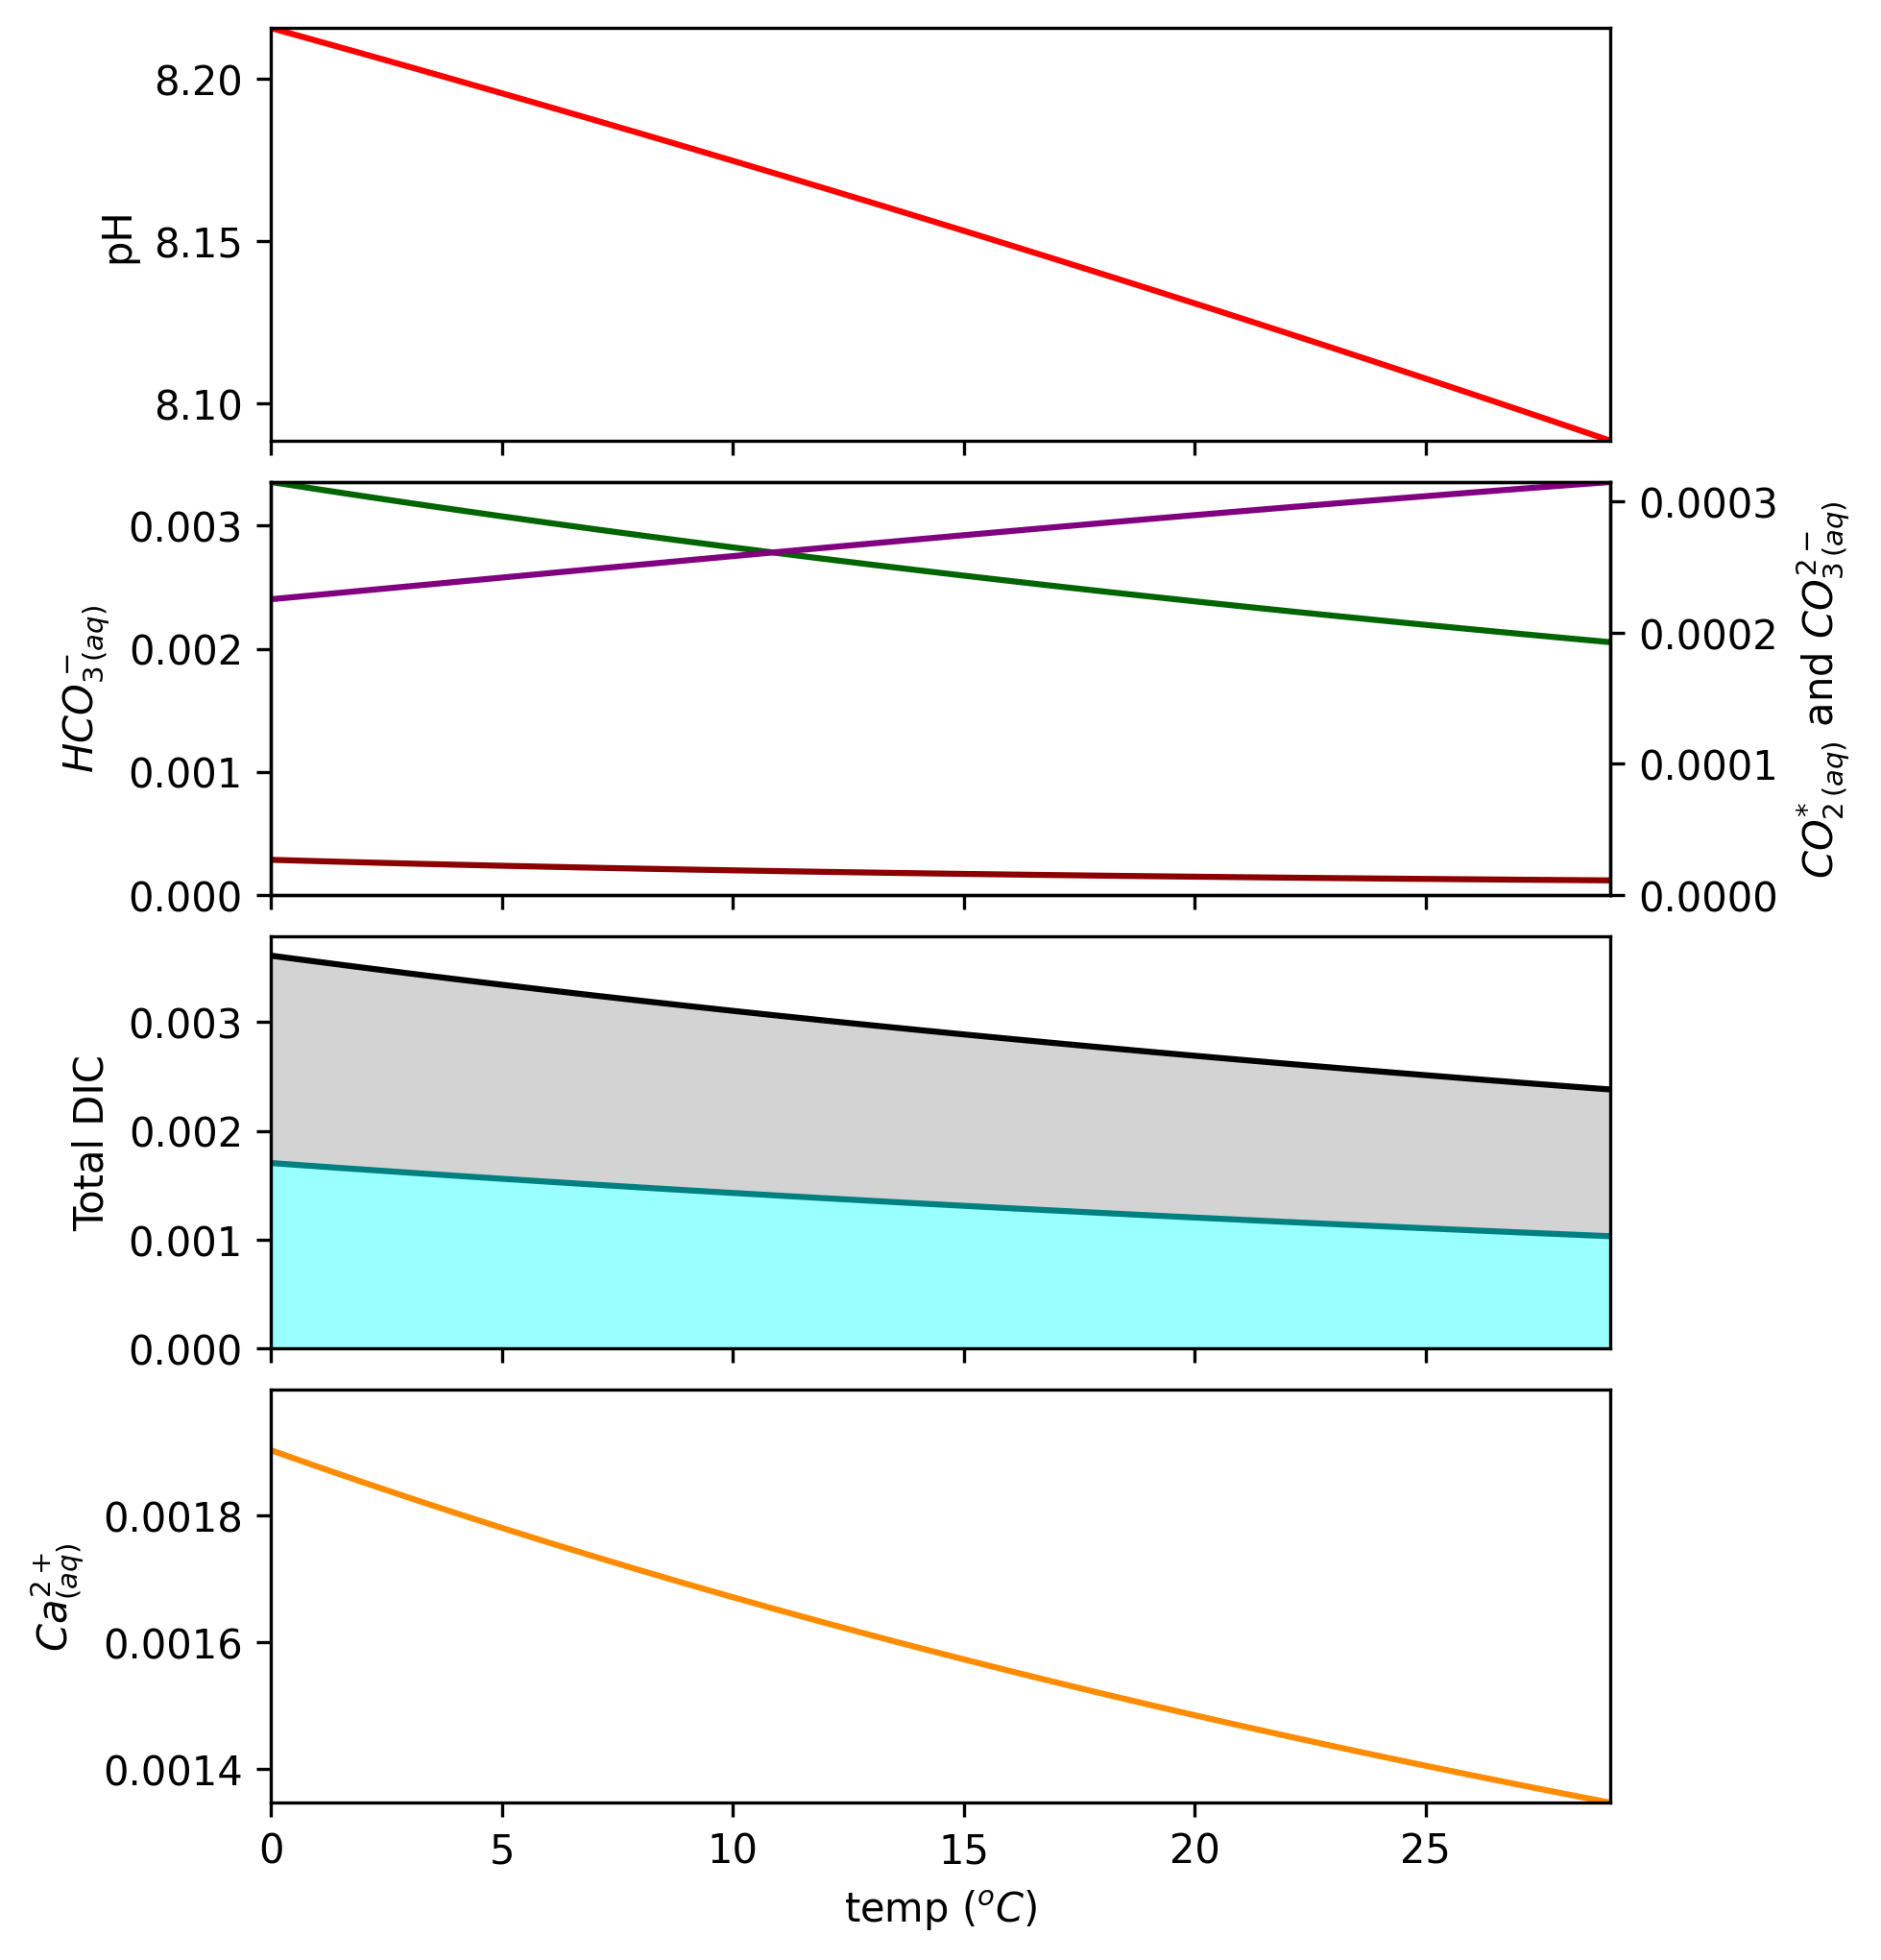

In [22]:
fig,axes=plt.subplots(4,1,figsize=(6,8),sharex=True)
axes[1].plot(tempList,dfRangeTemp['bct'],color=colors[2])
axes[1].set_ylabel(r"$ HCO^-_{3 \, (aq)}$")
axes[1].set_ylim([0,np.max(dfRangeTemp['bct'])])
ax1Sec = axes[1].twinx()
ax1Sec.plot(tempList,dfRangeTemp['car'],color=colors[3])
ax1Sec.plot(tempList,dfRangeTemp['co2'],color=colors[1])
ax1Sec.set_ylabel(r"$ CO_{2 \, (aq)}^{*}$"+" and "+r"$ CO^{2-}_{3 \, (aq)}$")
ax1Sec.set_ylim([0,np.max(dfRangeTemp['car'])])
dicT=np.array(dfRangeTemp['car']+dfRangeTemp['bct']+dfRangeTemp['co2'],dtype='float')
dicL=np.array(dfRangeTemp['cal'],dtype='float')
dicA=dicT-dicL
axes[2].plot(tempList,dicT,color="k")
axes[2].set_ylabel(r"Total DIC")
axes[2].plot(tempList,dicA,color="teal")
axes[2].fill_between(tempList, dicT, dicA, color="lightgrey")
axes[2].fill_between(tempList, dicA, 0, color=[.6,1,1])
axes[2].set_ylim([0,np.max(dicT)*1.05])
pH=-np.log10(np.array(dfRangeTemp['hdr'],dtype='float'))
axes[0].plot(tempList,pH,color=colors[4])
axes[0].set_ylim([np.min(pH),np.max(pH)])
axes[0].set_ylabel(r"pH")
axes[3].plot(tempList,dfRangeTemp['cal'],color=colors[6])
axes[3].set_ylabel(r"$ Ca^{2+}_{(aq)}$")
axes[3].set_ylim([np.min(dfRangeTemp['cal']),np.max(dfRangeTemp['cal']*1.05)])
axes[3].set_xlim([np.min(tempList),np.max(tempList)])
axes[3].set_xlabel("temp ($^oC$)")
fig.subplots_adjust(hspace=0.1)

In [23]:
#CO2 and carbonate ocean range of salinity
def FunCO2Car(x):
    f0=x[1]-(Kh)*(x[0])                         #Henry's Law
    f1=x[4]*x[2]-(Ka1*x[1])                     #Ka1 of dissolved CO2 to bicarbonate
    f2=x[4]*x[3]-(Ka2*x[2])                     #Ka2 of bicarbonate to carbonate
    f3=x[4]*x[5]-Kw                             #dissociation of water
    f4=x[6]*x[3]-Ksp                            #dissociation of calcium carbonate
    f5=x[2]+2*x[3]+x[5]-x[4]-2*x[6]             #charge balance (calcium is included but should not be present in CO2 only system)
    f6=x[0]-atm                                 #mass balance doesn't apply (carbon can come from atmospheric CO2 or calcium carbonate), atmospheric CO2 is fixed
    return np.array([f0,f1,f2,f3,f4,f5,f6])

ppm=420
temp=20+273.15
flgCorrectForTempAndSal=True
salList=np.arange(5,40,1)
dfRangeSal=pd.DataFrame(index=salList,columns=["atm","co2","bct","car","hdr","hox","cal","Kh","Ka1","Ka2","Kw","Ksp"])
for sal,index in zip(salList,range(len(salList))):
    Kh=np.exp(93.4517*(100/temp)-60.2409+23.3585*np.log(temp/100)+sal*(0.023517-0.023656*(temp/100)+0.004736*(temp/100)**2))
    dfRangeSal.iloc[index,7]=Kh
    Ka1=10**( (-3633.86/temp) + 61.2172 - 9.67770*np.log(temp) + 0.011555*sal - 0.0001152*sal**2 )
    dfRangeSal.iloc[index,8]=Ka1
    Ka2=10**( (-471.78/temp) - 25.9290 + 3.16967*np.log(temp) + 0.01781*sal - 0.0001122*sal**2 )
    dfRangeSal.iloc[index,9]=Ka2
    Kw=np.exp(-13847.26/temp+148.9652-23.6531*np.log(temp)+(118.67/temp-5.977+1.0495*np.log(temp))*sal**(1/2)-0.01615*sal)
    dfRangeSal.iloc[index,10]=Kw
    Ksp=10**( -171.9065 - 0.077993*temp + 2839.319/temp + 71.595*np.log10(temp) + (-0.77712+0.0028426*temp+178.34/temp)*sal**(1/2) - 0.07711*sal + 0.0041249*sal**1.5 )
    dfRangeSal.iloc[index,11]=Ksp
    if index==0:
      atm=ppm/1.0e6
      co2=atm*Kh                                  #calculates the initial dissolved CO2 using Henry's Law constant
      cal=np.sqrt(Ksp)                            #initial guess for calcium concentration based on Ksp
      car=np.sqrt(Ksp)                            #initial guess for carbonate concentration based on Ksp
      bct=np.sqrt(Ka1*co2) + np.sqrt(car*Kw/Ka2)  #initial guess for bicarbonate concentration based on sum of CO2 only and calcium carbonate
      hdr=10**-(8)                                #initial guess for hydronium concentration based on ocean pH
      hox=Kw/hdr                                  #initial guess for hydroxide based on hydronium
      x0=np.array([atm,co2,bct,car,hdr,hox,cal])
    else:
      atm=ppm/1.0e6
      x0=np.array(dfRangeSal.iloc[index-1,0:7],dtype=float)
    res1=least_squares(FunCO2Car,x0,bounds=(0, 1),gtol=None,ftol=None,xtol=2.5e-16,max_nfev=100000,method="dogbox",jac='3-point')
    x=res1.x
    if res1.message!='`xtol` termination condition is satisfied.':
      print(str(ppm)+" ppm, "+res1.message+" opt="+str(res1.optimality))
    dfRangeSal.iloc[index,0:7]=x
dfRangeSal

,atm,co2,bct,car,hdr,hox,cal,Kh,Ka1,Ka2,Kw,Ksp
5,0.00042,0.000016,0.00148,0.000062,0.0,0.000002,0.000802,0.03817,0.000001,0.0,0.0,0.0
6,0.00042,0.000016,0.001559,0.00007,0.0,0.000002,0.00085,0.037975,0.000001,0.0,0.0,0.0
7,0.00042,0.000016,0.00163,0.000078,0.0,0.000002,0.000894,0.037781,0.000001,0.0,0.0,0.0
8,0.00042,0.000016,0.001695,0.000086,0.0,0.000002,0.000934,0.037587,0.000001,0.0,0.0,0.0
9,0.00042,0.000016,0.001753,0.000093,0.0,0.000002,0.000971,0.037395,0.000001,0.0,0.0,0.0
10,0.00042,0.000016,0.001807,0.000101,0.0,0.000003,0.001006,0.037204,0.000001,0.0,0.0,0.0
11,0.00042,0.000016,0.001856,0.000109,0.0,0.000003,0.001038,0.037013,0.000001,0.0,0.0,0.0
12,0.00042,0.000015,0.001901,0.000116,0.0,0.000003,0.001068,0.036824,0.000001,0.0,0.0,0.0
13,0.00042,0.000015,0.001942,0.000124,0.0,0.000003,0.001097,0.036635,0.000001,0.0,0.0,0.0
14,0.00042,0.000015,0.001981,0.000132,0.0,0.000003,0.001124,0.036448,0.000001,0.0,0.0,0.0


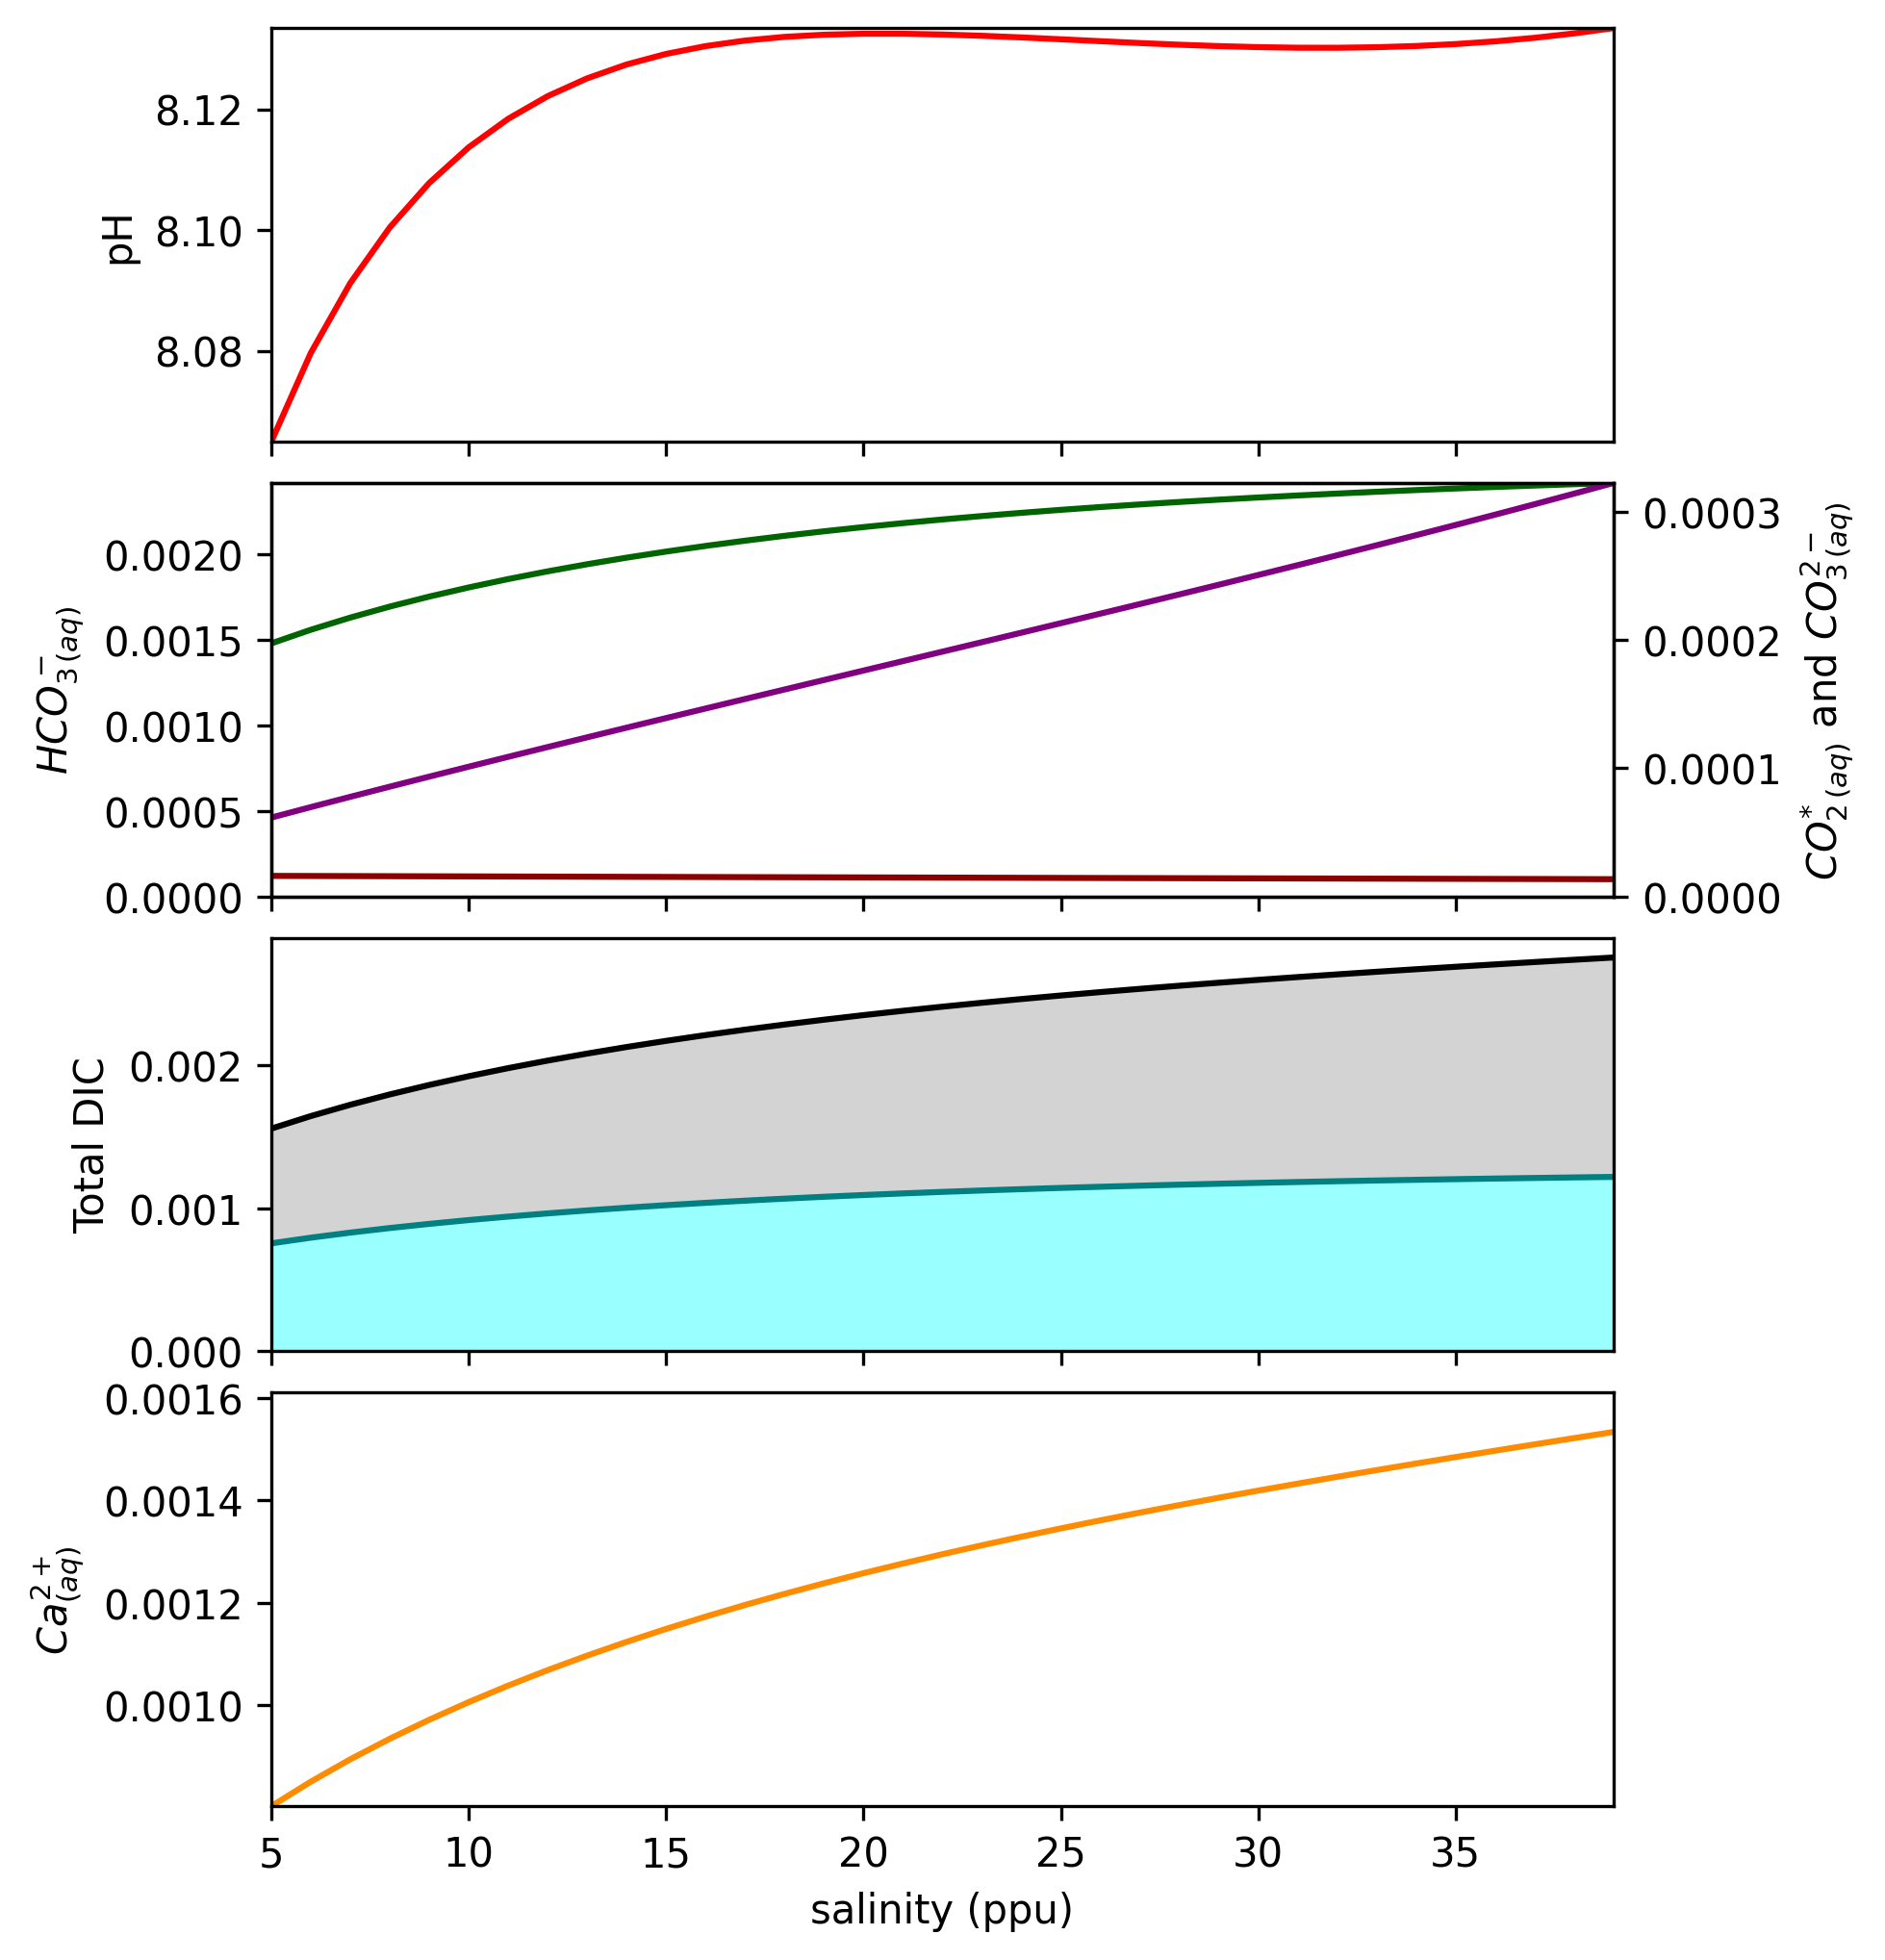

In [24]:
fig,axes=plt.subplots(4,1,figsize=(6,8),sharex=True)
axes[1].plot(salList,dfRangeSal['bct'],color=colors[2])
axes[1].set_ylabel(r"$ HCO^-_{3 \, (aq)}$")
axes[1].set_ylim([0,np.max(dfRangeSal['bct'])])
ax1Sec = axes[1].twinx()
ax1Sec.plot(salList,dfRangeSal['car'],color=colors[3])
ax1Sec.plot(salList,dfRangeSal['co2'],color=colors[1])
ax1Sec.set_ylabel(r"$ CO_{2 \, (aq)}^{*}$"+" and "+r"$ CO^{2-}_{3 \, (aq)}$")
ax1Sec.set_ylim([0,np.max(dfRangeSal['car'])])
dicTotal=np.array(dfRangeSal['car']+dfRangeSal['bct']+dfRangeSal['co2'],dtype='float')
dicLimestone=np.array(dfRangeSal['cal'],dtype='float')
dicAtm=dicTotal-dicLimestone
axes[2].plot(salList,dicTotal,color="k")
axes[2].set_ylabel(r"Total DIC")
axes[2].plot(salList,dicAtm,color="teal")
axes[2].fill_between(salList, dicTotal, dicAtm, color="lightgrey")
axes[2].fill_between(salList, dicAtm, 0, color=[.6,1,1])
axes[2].set_ylim([0,np.max(dicTotal)*1.05])
pH=-np.log10(np.array(dfRangeSal['hdr'],dtype='float'))
axes[0].plot(salList,pH,color=colors[4])
axes[0].set_ylim([np.min(pH),np.max(pH)])
axes[0].set_ylabel(r"pH")
axes[3].plot(salList,dfRangeSal['cal'],color=colors[6])
axes[3].set_ylabel(r"$ Ca^{2+}_{(aq)}$")
axes[3].set_ylim([np.min(dfRangeSal['cal']),np.max(dfRangeSal['cal']*1.05)])
axes[3].set_xlim([np.min(salList),np.max(salList)])
axes[3].set_xlabel("salinity (ppu)")
fig.subplots_adjust(hspace=0.1)